##  Adv Machine Learning project - FHNW Data Science Specialization module

============================

# 1 Import libraries

In [26]:
# Remove warning about future deprecation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# data manipulation
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import re
from functools import reduce

# Unblanaced dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SMOTEN

# Statistical functions
from scipy import stats

# modeling utilities
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, OrdinalEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.experimental import enable_iterative_imputer # enables sklearn.impute.IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.ensemble import RandomForestClassifier, StackingClassifier , HistGradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, precision_recall_curve,  confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn import set_config
set_config(display="diagram")

# Additional models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%matplotlib inline
import seaborn as sns

# misc
from tqdm import tqdm  
from datetime import datetime

# 2 Helper functions and Custom Transformers

In [3]:
class FeatureUnion_CT(BaseEstimator, TransformerMixin):
    # FeatureUnion but for pandas DataFrames

    def __init__(self, transformer_list):
        N = len(transformer_list[0])
        if N == 3:
            self.transformer_list = [(name, model) for (name, model, _) in transformer_list]
        elif N == 2:
            self.transformer_list = [(name, model) for (name, model) in transformer_list]
        else:
            print("Transformer dimension not valid")
            self.transformer_list = None

    def fit(self, X, y=None):
        for (_, model) in self.transformer_list:
            model.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [model.transform(X) for _, model in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion
    
    
class OHE_CT(BaseEstimator, TransformerMixin):
    # OHE for pandas DataFrames

    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, df, y=None):
        self.ohe = OneHotEncoder(sparse = False)
        if self.columns==None:
            self.ohe.fit(df)
        else:
            self.ohe.fit(df.loc[:, self.columns])
        return self

    def transform(self, df):
        if self.columns==None:
            Xohe = self.ohe.transform(df)
            self.columns = df.columns
        else:
            Xohe = self.ohe.transform(df.loc[:, self.columns])
        
        index  = []
        for col in self.columns:
            unique_feature_list = df[col].unique().tolist()
            unique_feature_list.sort()
            [index.append(col + "." + feature) for feature in unique_feature_list] 
        
        Xohe_df = pd.DataFrame(Xohe, columns = index)
        return Xohe_df

class OrdinalEncoder_CT(BaseEstimator, TransformerMixin):
    # OHE for pandas DataFrames

    def __init__(self, categories='auto', columns=None):
        self.categories = categories
        self.columns = columns
        # self.unknown_value = np.nan
    
    def fit(self, df, y=None):
        self.oe = OrdinalEncoder(categories=self.categories, handle_unknown='use_encoded_value', unknown_value=-1)        
        if self.columns==None:
            self.oe.fit(df)
        else:
            self.oe.fit(df.loc[:, self.columns], y=None)
        return self

    def transform(self, df):
        X_df = df.copy()
        if self.columns==None:
            self.columns = X_df.columns
            Xoe = self.oe.transform(df)
        else:
            Xoe = self.oe.transform(df.loc[:, self.columns])
        
        Xoe_df = pd.DataFrame(Xoe, columns=self.columns)
        
        X_df[Xoe_df.columns] = Xoe_df 
        return Xoe_df

class ColumnsLabelBinarizer_CT(BaseEstimator, TransformerMixin):
    # input multiple cols, implement LBin on each, return combined results in df

    def __init__(self):
        self.lbin = []

    def fit(self, df, y=None):
        columns = df.columns.tolist()
        for i, cname in enumerate(columns):
            lb = LabelBinarizer()
            lb.fit(df[cname])
            self.lbin.append(lb)
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        columns = df.columns.tolist()
        Xlbin_df = pd.DataFrame()
        for i, cname in enumerate(columns):
            lb = self.lbin[i]
            Xlbin = lb.transform(df[cname])
            Xlbin_df[cname] = pd.Series(Xlbin.flatten() , name=cname)
        return Xlbin_df
    
class GetDummies_CT(TransformerMixin):
    
    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum
    
class ColumnExtractor_CT(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols
    
class GroupFeatureValues_CT(BaseEstimator, TransformerMixin):
    # FunctionTransformer but for pandas DataFrames

    def __init__(self, features_dict_list):
        self.features_dict_list = features_dict_list

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, df):
        df_t = df.copy()
        for feature_dict in self.features_dict_list:
          for feature_name, values_dict in feature_dict.items():
              for new_value, list_old_values in values_dict.items():
                  df_t[feature_name].replace(to_replace = list_old_values, value = new_value, inplace = True)
            
        df_t = pd.DataFrame(df_t, index=df.index, columns=df.columns)
        return df_t   
    

class StdScaler_CT(BaseEstimator, TransformerMixin):
    # StandardScaler but for pandas DataFrames

    def __init__(self, columns = None):
        self.ss = None
        self.mean_ = None
        self.scale_ = None
        self.columns = columns

    def fit(self, df, y=None):
        self.ss = StandardScaler()
        if self.columns == None:
            self.columns = df.columns.tolist()
        self.ss.fit(df[self.columns])
        self.mean_ = pd.Series(self.ss.mean_, index=df[self.columns].columns)
        self.scale_ = pd.Series(self.ss.scale_, index=df[self.columns].columns)
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        Xss = df.copy()
        Xss[self.columns] = self.ss.transform(df[self.columns])
        Xscaled = pd.DataFrame(Xss, index=df.index, columns=df.columns)
        return Xscaled
    

class MinMaxScaler_CT(BaseEstimator, TransformerMixin):
    # StandardScaler but for pandas DataFrames

    def __init__(self, columns=None):
        self.mms = None
        self.columns = columns

    def fit(self, X, y=None):
        self.mms = MinMaxScaler()
        if self.columns==None:
            self.columns=X.columns
        self.mms.fit(X.loc[:, self.columns])
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        Xmms = df.copy()
        if self.columns==None:
            self.columns=df.columns  
        Xmms[self.columns] = self.mms.transform(df.loc[:, self.columns])
        Xmms_df = pd.DataFrame(Xmms, columns=df.columns)
        return Xmms_df
    
class Function_CT(TransformerMixin):
    # FunctionTransformer but for pandas DataFrames

    def __init__(self, *args, **kwargs):
        self.ft = FunctionTransformer(*args, **kwargs)

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        Xt = self.ft.transform(X)
        Xt = pd.DataFrame(Xt, index=X.index, columns=X.columns)
        return Xt

class IterativeImputer_CT(TransformerMixin):
    # Imputer but for pandas DataFrames

    def __init__(self):
        self.imp = None

    def fit(self, X, y=None):
        self.imp = IterativeImputer()
        self.imp.fit(X)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

class Model_CT(BaseEstimator, TransformerMixin):
    # FunctionTransformer but for pandas DataFrames

    def __init__(self, model):
        # kargs must contain {"y_column": "salary", "model" : <ML_model>}
        # self.y_column = y_column
        self.model = model
        # self.kwargs = kwargs
    

    def fit(self, X, y=None):
        self.model.fit(X[:,:-1], X[:,-1])
        return self

    def transform(self, X):
        pass
    
    def predict (self, X):
        Ypredict = self.model.predict(X[:,:-1])
        return Ypredict


def replace_value(df, to_replace, value):
    df2 = df.copy()
    df2.replace(to_replace = to_replace, value = value, inplace = True)
    return df2

def evaluate_correlation(df):
    print("Evaluating correlation matrix...")
    features = df.columns.tolist()
    corr_matrix = pd.DataFrame(index=features)
    tqdm.pandas(desc="progress bar")

    for col in features:
        corr_vector = []    
        for row in tqdm(features, desc=col):  
            if len(df[col].unique()) >= 2 or len(df[row].unique()) >= 2:
                corr = stats.spearmanr(df[row], df[col])[0]
            else:
                corr = stats.pointbiserialr(df[row], df[col])[0]
            corr_vector.append(corr.round(2))
        corr_matrix[col] = corr_vector
    print("done.")
    return corr_matrix


def plot_correlation(corr_matrix, width = 20):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(width, round(width*0.6)))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _ = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True)
    plt.show()

# 3 Data Loading

In [4]:
# Setting column names
columns = ["age","workclass" ,"final-weight","education","education-num","marital-status","occupation", "relationship", "race", "sex", "capital-gain",
            "capital-loss", "hours-per-week", "native-country", "salary" ]

# Reading datasets
train_df = pd.read_csv('data/adult.data', names=columns, header=None, skipinitialspace = True)
test_df = pd.read_csv('data/adult.test', names=columns, header=None, skipinitialspace = True)
test_df["salary"] = test_df["salary"].apply(lambda x: x.replace('.', ''))

print("Training set:") #, train_df.columns)
print(train_df.sample(frac=1).tail(3))

print("Test set:") #, test_df.columns)
print(test_df.sample(frac=1).tail(3))

Training set:
       age  workclass  final-weight     education  education-num      marital-status     occupation relationship   race   sex  capital-gain  capital-loss  hours-per-week native-country salary
8441   40   Private    169995        HS-grad       9              Divorced            Craft-repair   Unmarried    White  Male  0             0             40              United-States  <=50K
13093  50   State-gov  24647         Some-college  10             Married-civ-spouse  Adm-clerical   Husband      White  Male  0             0             40              United-States  >50K 
11389  37   Private    167396        HS-grad       9              Married-civ-spouse  Other-service  Husband      White  Male  0             0             40              Guatemala      <=50K
Test set:
       age         workclass  final-weight     education  education-num      marital-status      occupation    relationship   race     sex  capital-gain  capital-loss  hours-per-week native-country  \
1341   

# 4. Data exploration

## 4.1 General overview

### Data type investigation

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   final-weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


- Only integer (numerical) and object (categorical) datatype

### Identification of categorical vs numerical variables

In [6]:
# Separating numerical & categorical variables
categorical_var = [var for var in train_df.columns if train_df[var].dtype==object]
numerical_var = [var for var in train_df.columns if train_df[var].dtype!=object]

print("categorical_var:", categorical_var)
print("numerical_var:", numerical_var)


categorical_var: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'salary']
numerical_var: ['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


### Search for Null, NA values

In [7]:
# Check on NA values
print("NaNs check:")
train_df.isna().sum()

NaNs check:


age               0
workclass         0
final-weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

- No NaNs is a bit suspect. Let's investigate further.

## 4.2. Explore numerical features 

In [8]:
# Plot a random sample
train_df[numerical_var].sample(frac=1).head()

,age,final-weight,education-num,capital-gain,capital-loss,hours-per-week
234,28,76714,15,0,0,55
9262,27,29807,9,0,0,40
6630,20,227554,10,0,0,18
10218,52,135339,10,0,0,40
32059,55,183580,10,0,0,38


### Limits and statistical moments of numerical variables

In [9]:
print ("Statistical description of numerical values:")
train_df[numerical_var].describe().T

Statistical description of numerical values:


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
final-weight,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


### Histograms of numerical variables

[]

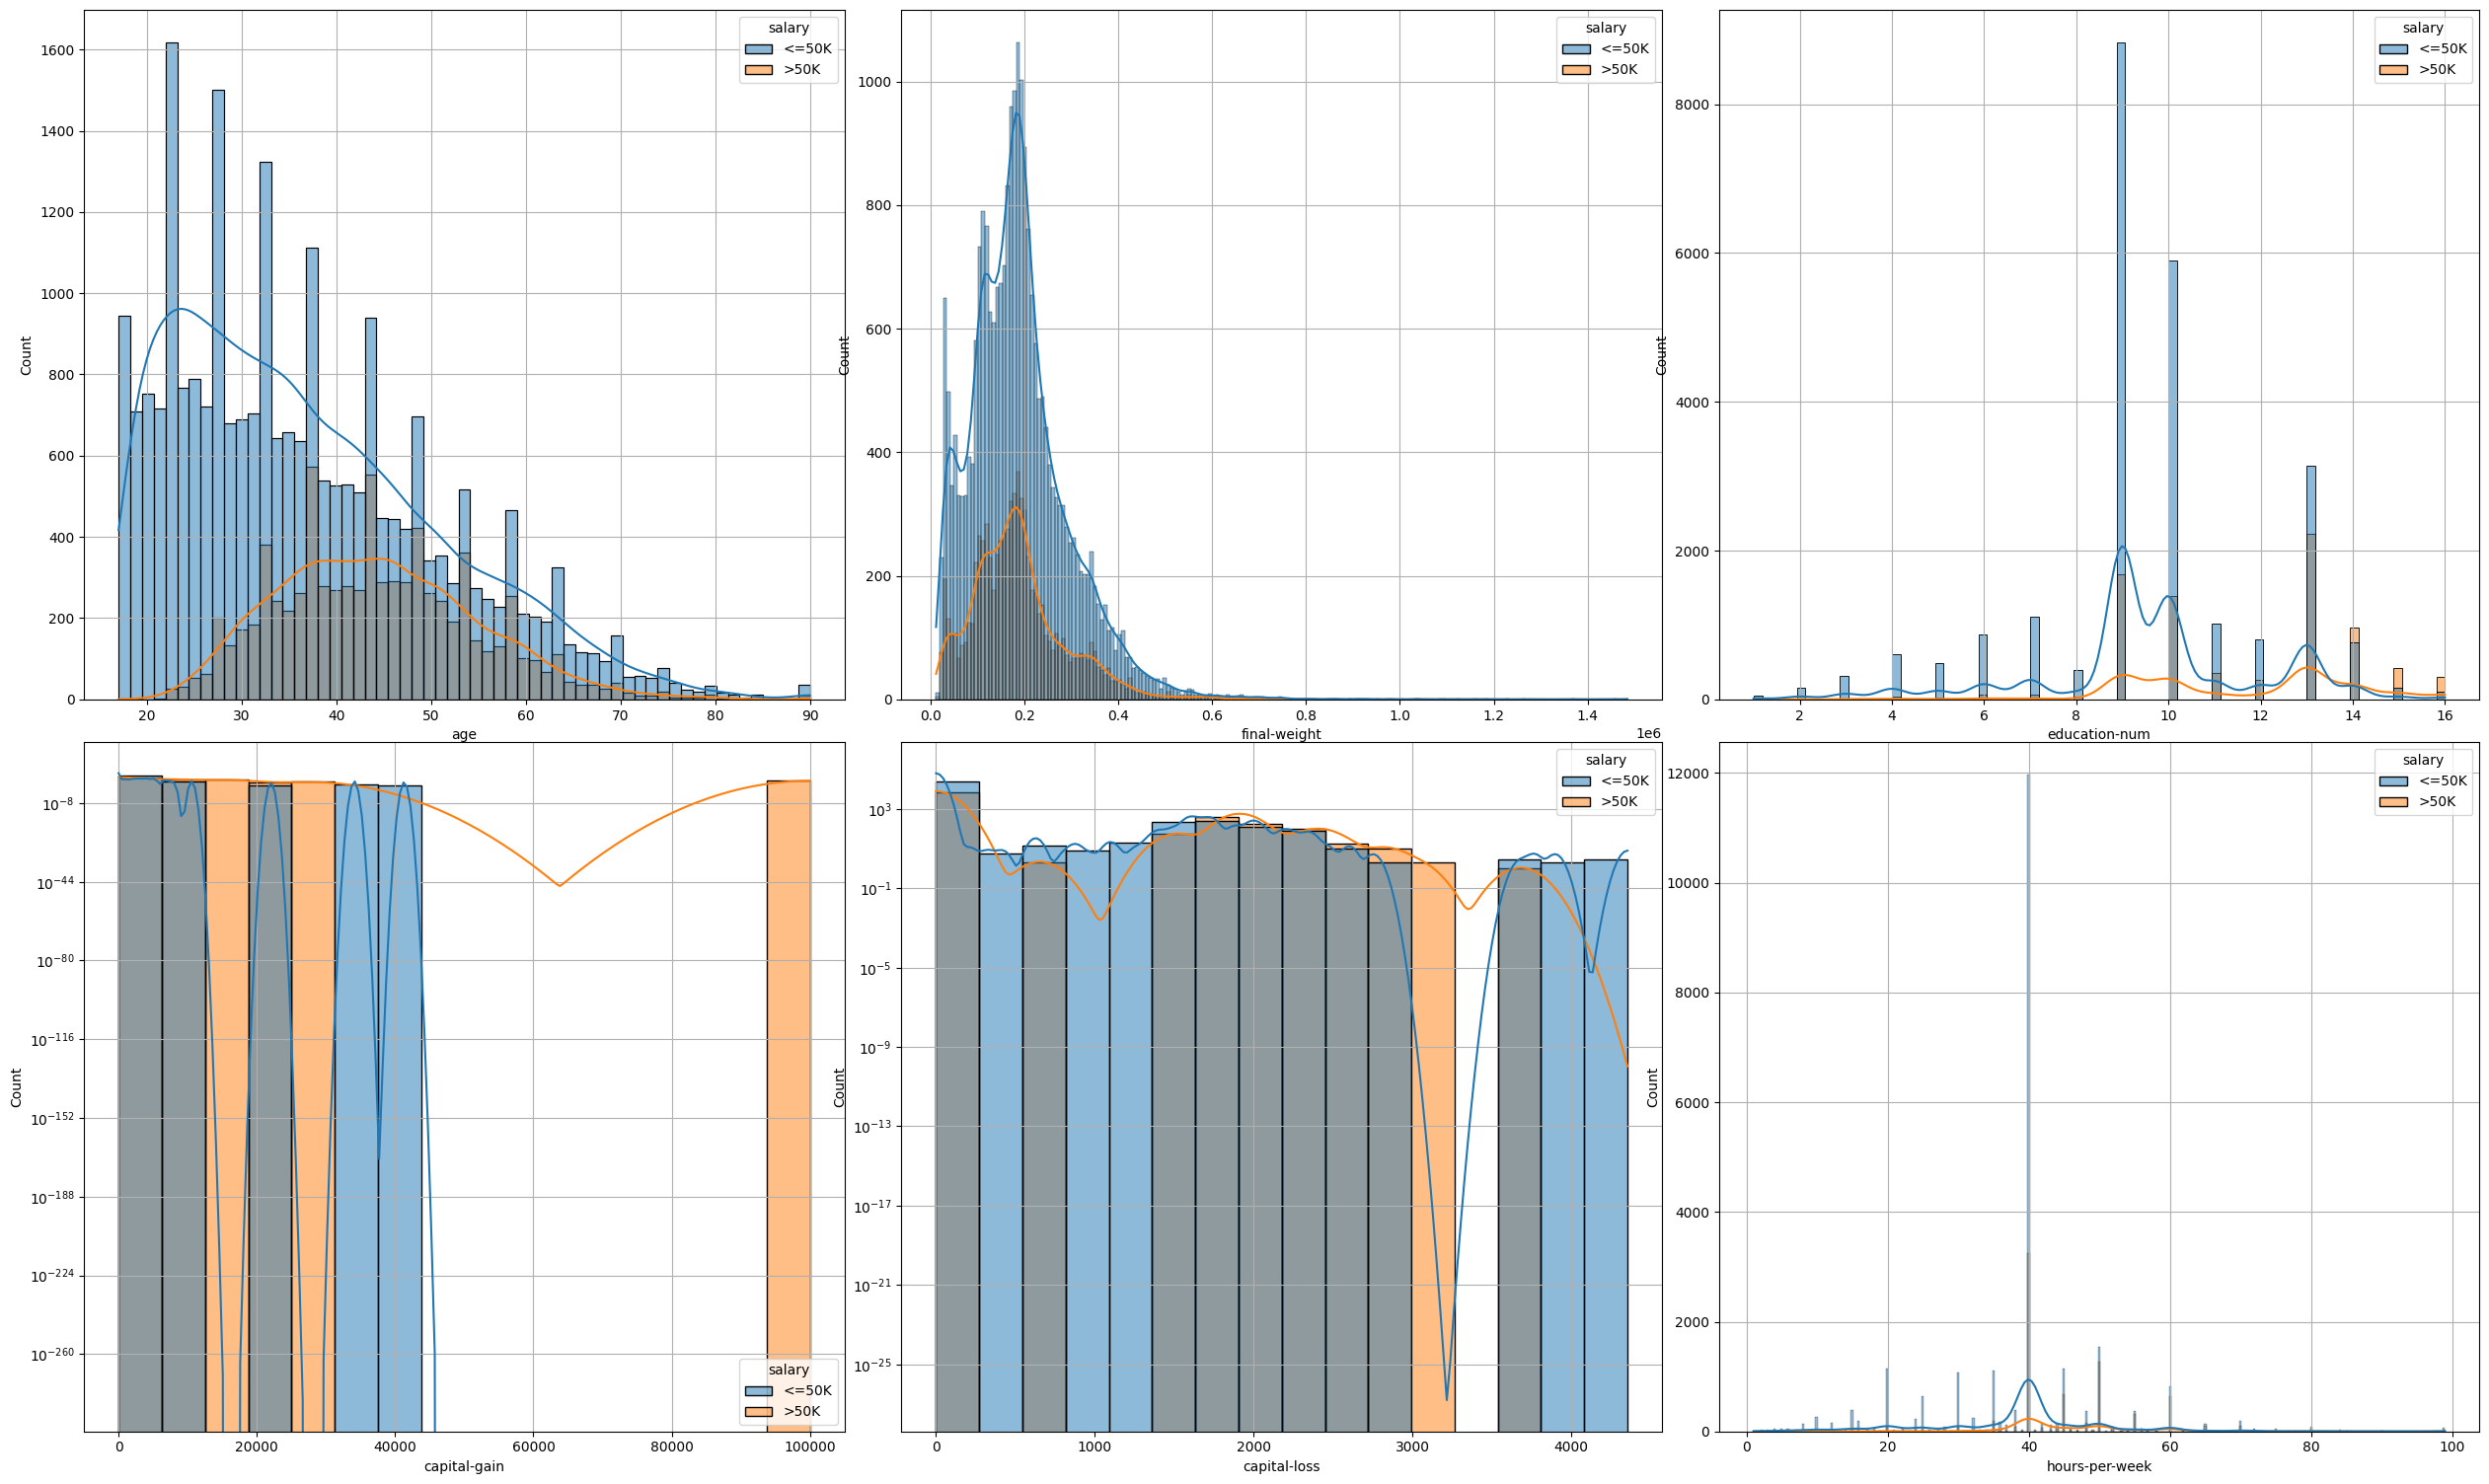

In [10]:
N = len(numerical_var)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,figsize=(25,15))
fig.tight_layout(h_pad=1)

for n, col in enumerate(numerical_var):
    # print(col)
    i = int(n // K)
    j = int(n % K)
    sns.histplot(data=train_df, x=col, hue="salary", kde=True, stat = "count", ax=axes[i,j])
    axes[i, j].grid()

axes[1,0].semilogy()
axes[1,1].semilogy()


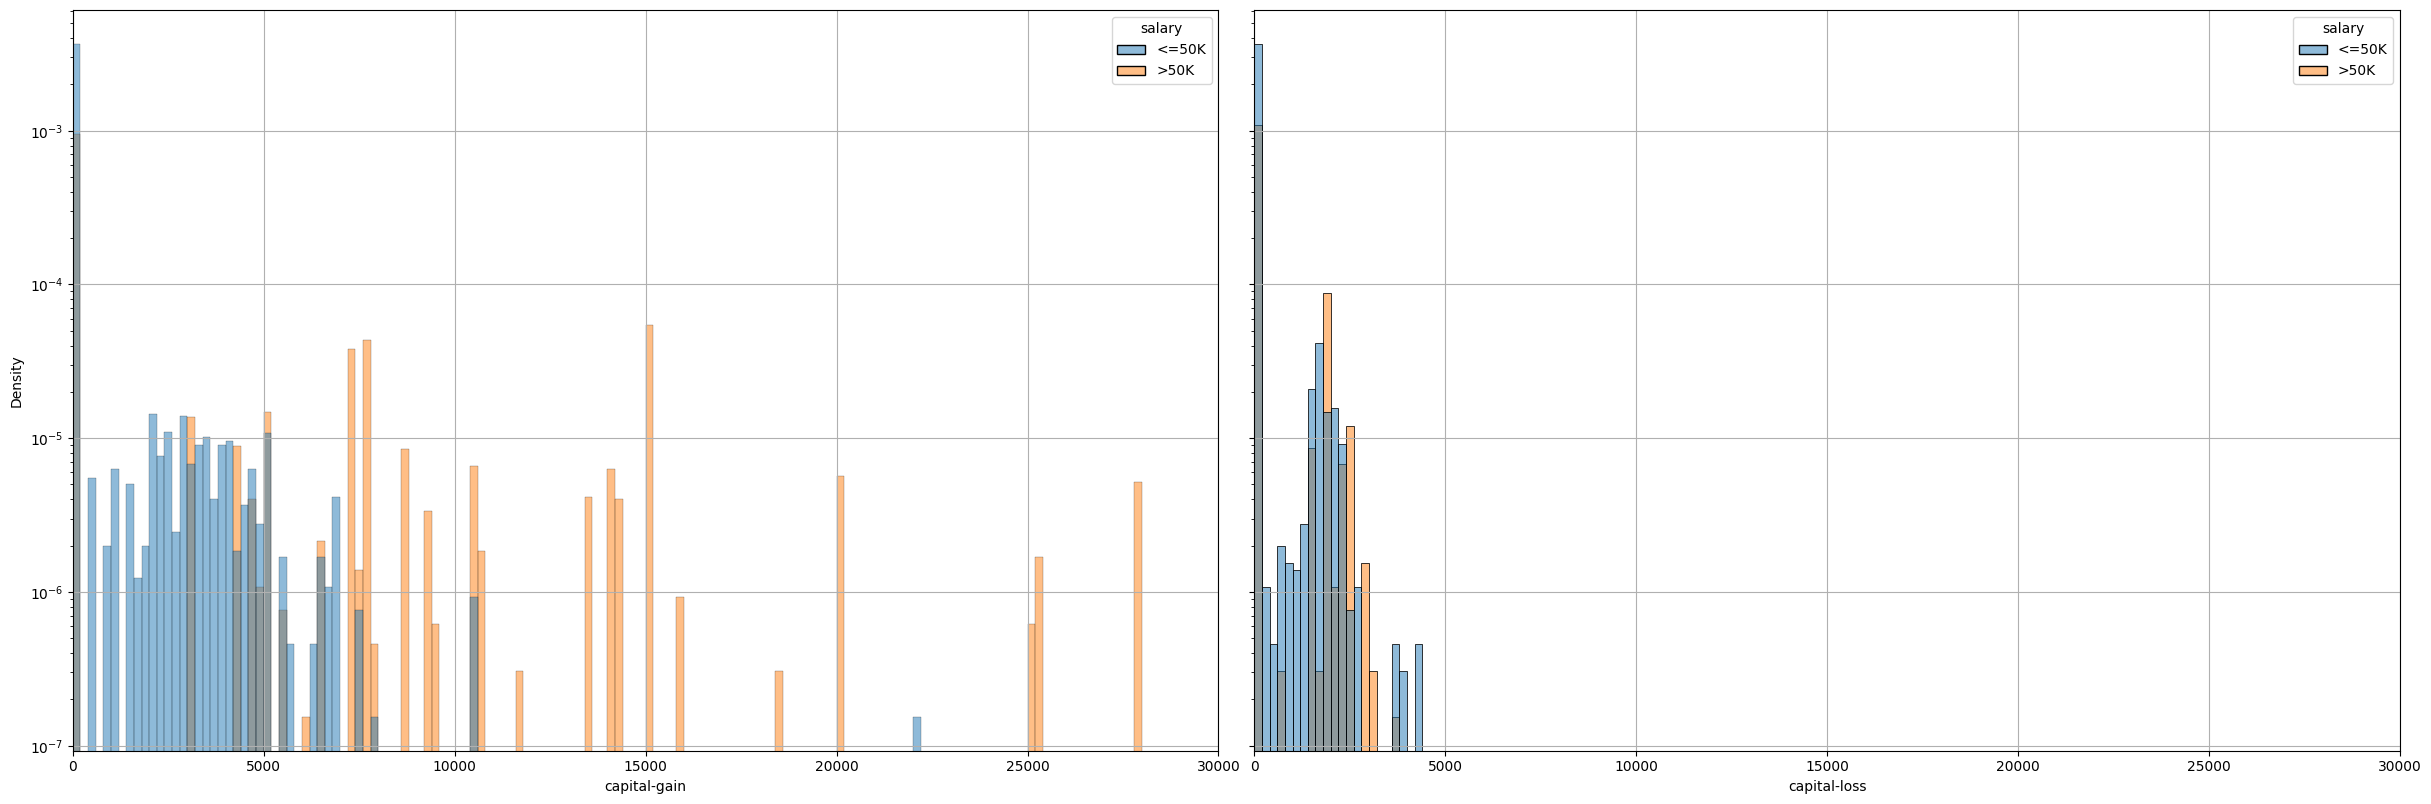

In [11]:
# 'age',  'final-weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
fig, axes= plt.subplots(1,2,figsize=(24,8), sharey=True, sharex=True)
fig.tight_layout(w_pad=1)

sns.histplot(data=train_df, x="capital-gain", hue="salary", kde=False, binwidth=200, stat = "density", ax=axes[0]).set(xlim=(0,30000), yscale="log")
axes[0].grid()

sns.histplot(data=train_df, x="capital-loss", hue="salary", kde=False, binwidth=200, stat = "density", ax=axes[1]).grid()


### Some features could be maybe be better represented using a Box-Cox transformation. 

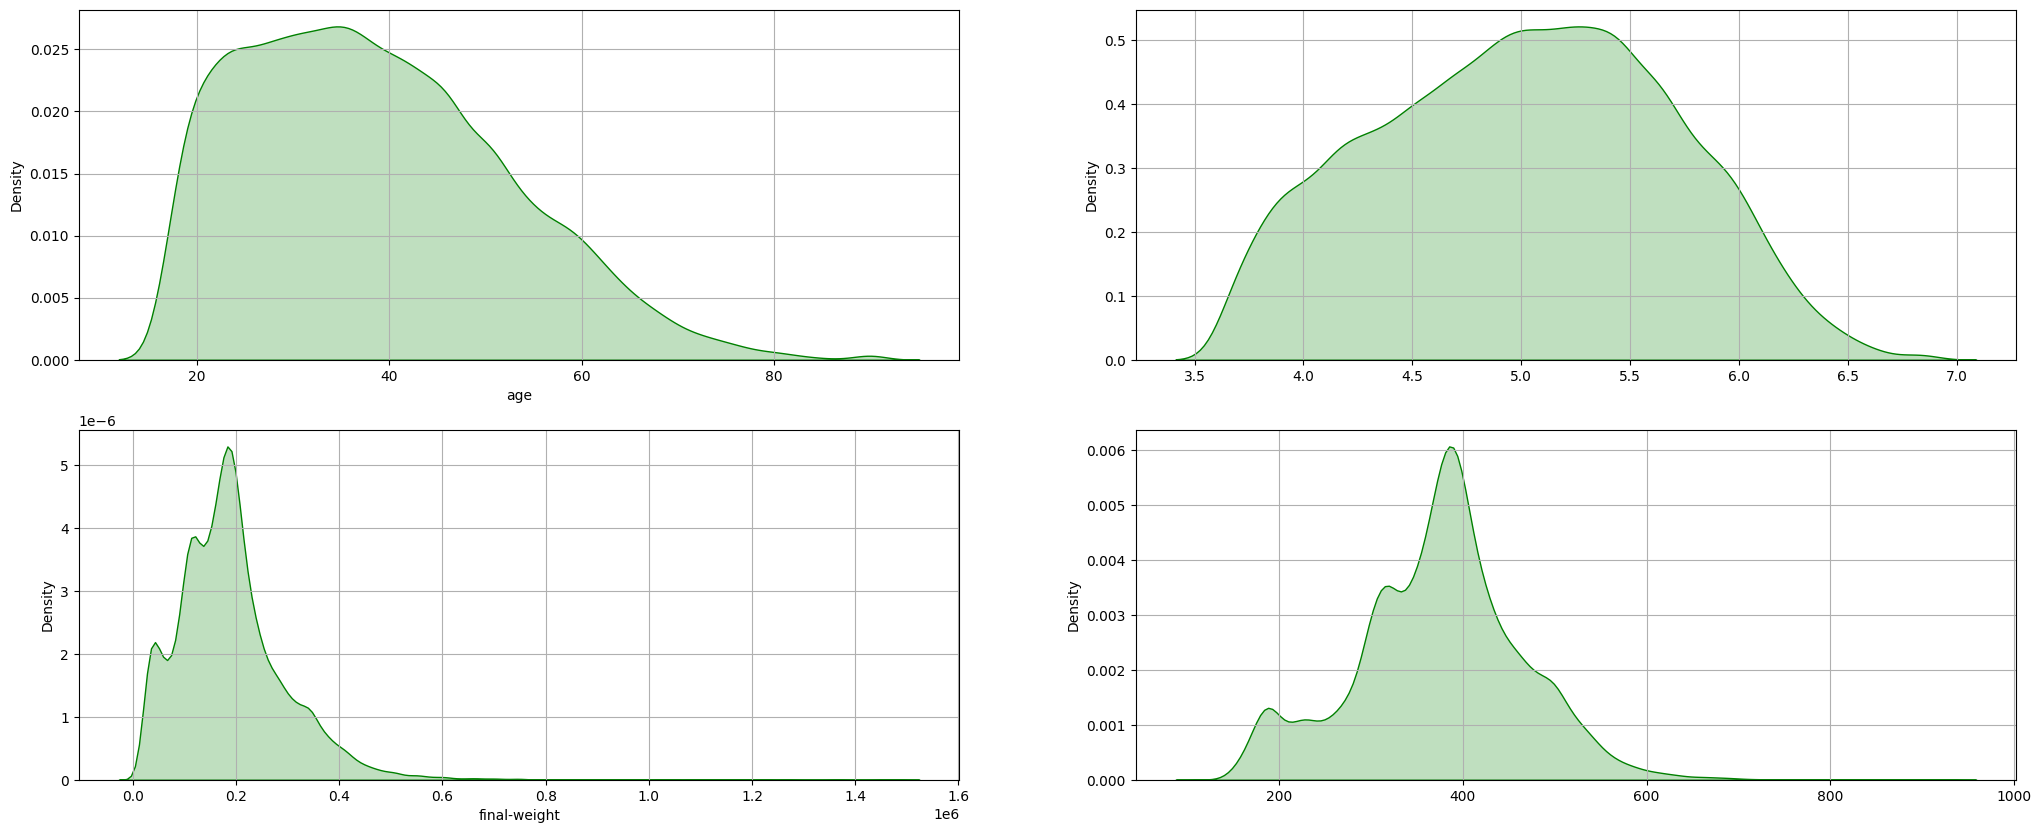

In [12]:
fig, axes = plt.subplots(2,2,figsize=(25,10))

fitted_data_age, fitted_lambda_age = stats.boxcox(train_df["age"])
fitted_data_weight, fitted_lambda_weight = stats.boxcox(train_df["final-weight"])
fitted_data_hours, fitted_lambda_hours = stats.boxcox(train_df["hours-per-week"])

boxcox_df = pd.DataFrame(fitted_data_age, columns=["BoxCox(age)"])
boxcox_df["BoxCox(final-weight)"] = fitted_data_weight
boxcox_df["BoxCox(hours)"] = fitted_data_hours

# sns.distplot(train_df["final-weight"], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, label = "final-weight", color ="green", ax = axes[0]).grid()
# sns.distplot(fitted_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, label = "weight after box-cox", color ="green", ax = axes[1]).grid()

sns.kdeplot(train_df["age"], label = "final-weight", color ="green", fill = True, ax = axes[0,0]).grid()
sns.kdeplot(fitted_data_age, label = "weight after box-cox", color ="green", fill = True, ax = axes[0,1]).grid()

sns.kdeplot(train_df["final-weight"], label = "final-weight", color ="green", fill = True, ax = axes[1,0]).grid()
sns.kdeplot(fitted_data_weight, label = "weight after box-cox", color ="green", fill = True, ax = axes[1,1]).grid()


### Some combined features plots might also give us some idea on the correlation between various numerical features

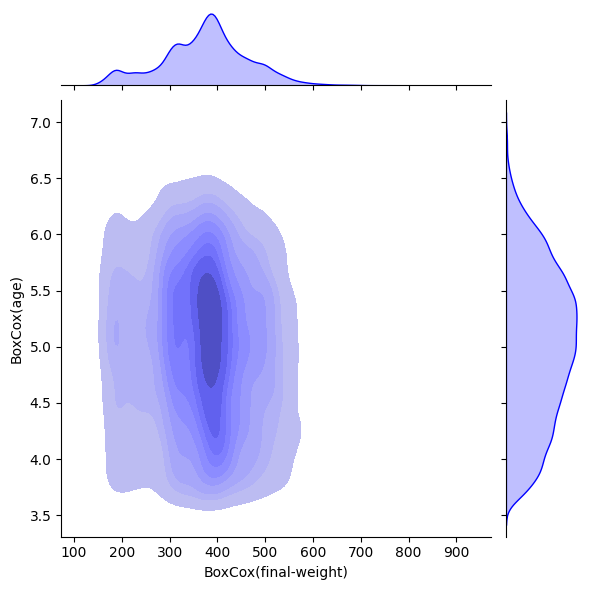

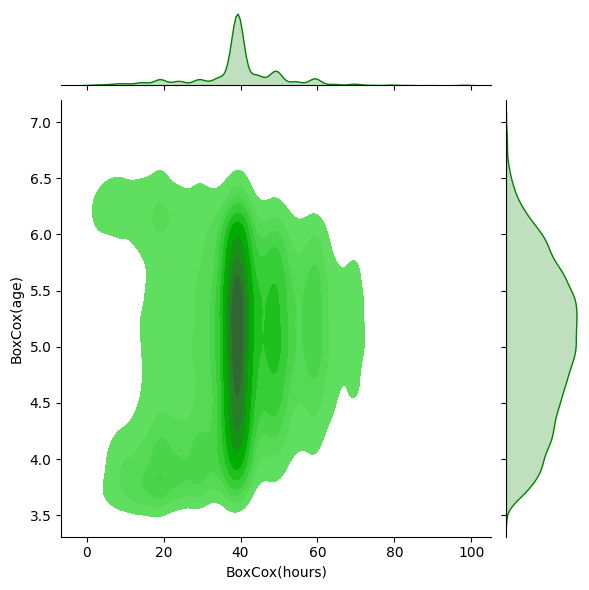

In [13]:
J1 = sns.jointplot(data=boxcox_df, x="BoxCox(final-weight)", y="BoxCox(age)",  kind="kde",  color="b", fill=True)
J2 = sns.jointplot(data=boxcox_df, x="BoxCox(hours)", y ="BoxCox(age)", kind="kde", color="g", fill=True)


## 4.3. Explore categorical features 

### Check unique values of categorical features 

In [14]:

pd.Series(list(map(set,train_df[categorical_var].values.T)), index=train_df[categorical_var].columns)

workclass         {Self-emp-inc, Without-pay, ?, Self-emp-not-inc, Federal-gov, Never-worked, Private, State-gov, Local-gov}                                                                                                                                                                                                                                                                                                                         
education         {5th-6th, Prof-school, 1st-4th, HS-grad, Assoc-voc, 7th-8th, Masters, Assoc-acdm, Preschool, Bachelors, 10th, Doctorate, 11th, 12th, Some-college, 9th}                                                                                                                                                                                                                                                                            
marital-status    {Divorced, Never-married, Married-AF-spouse, Married-spouse-absent, Married-civ-spouse, Separated, Widowed

- It looks like some values are unknown (marked with ?). We'll need to replace those with NaNs and maybe use an imputer to fill-in values.   

- Furthermore some categorical features have many values which might reduce the effectiveness of the model so we may want to group some features together to improve the model accuracy (e.g many countries can be grouped against a specific metric like their GDP or development status).  

- Finally some features are semantically very close (e.g separated vs divorced, education vs education)

### Display proportions of feature values within each categorical variables 

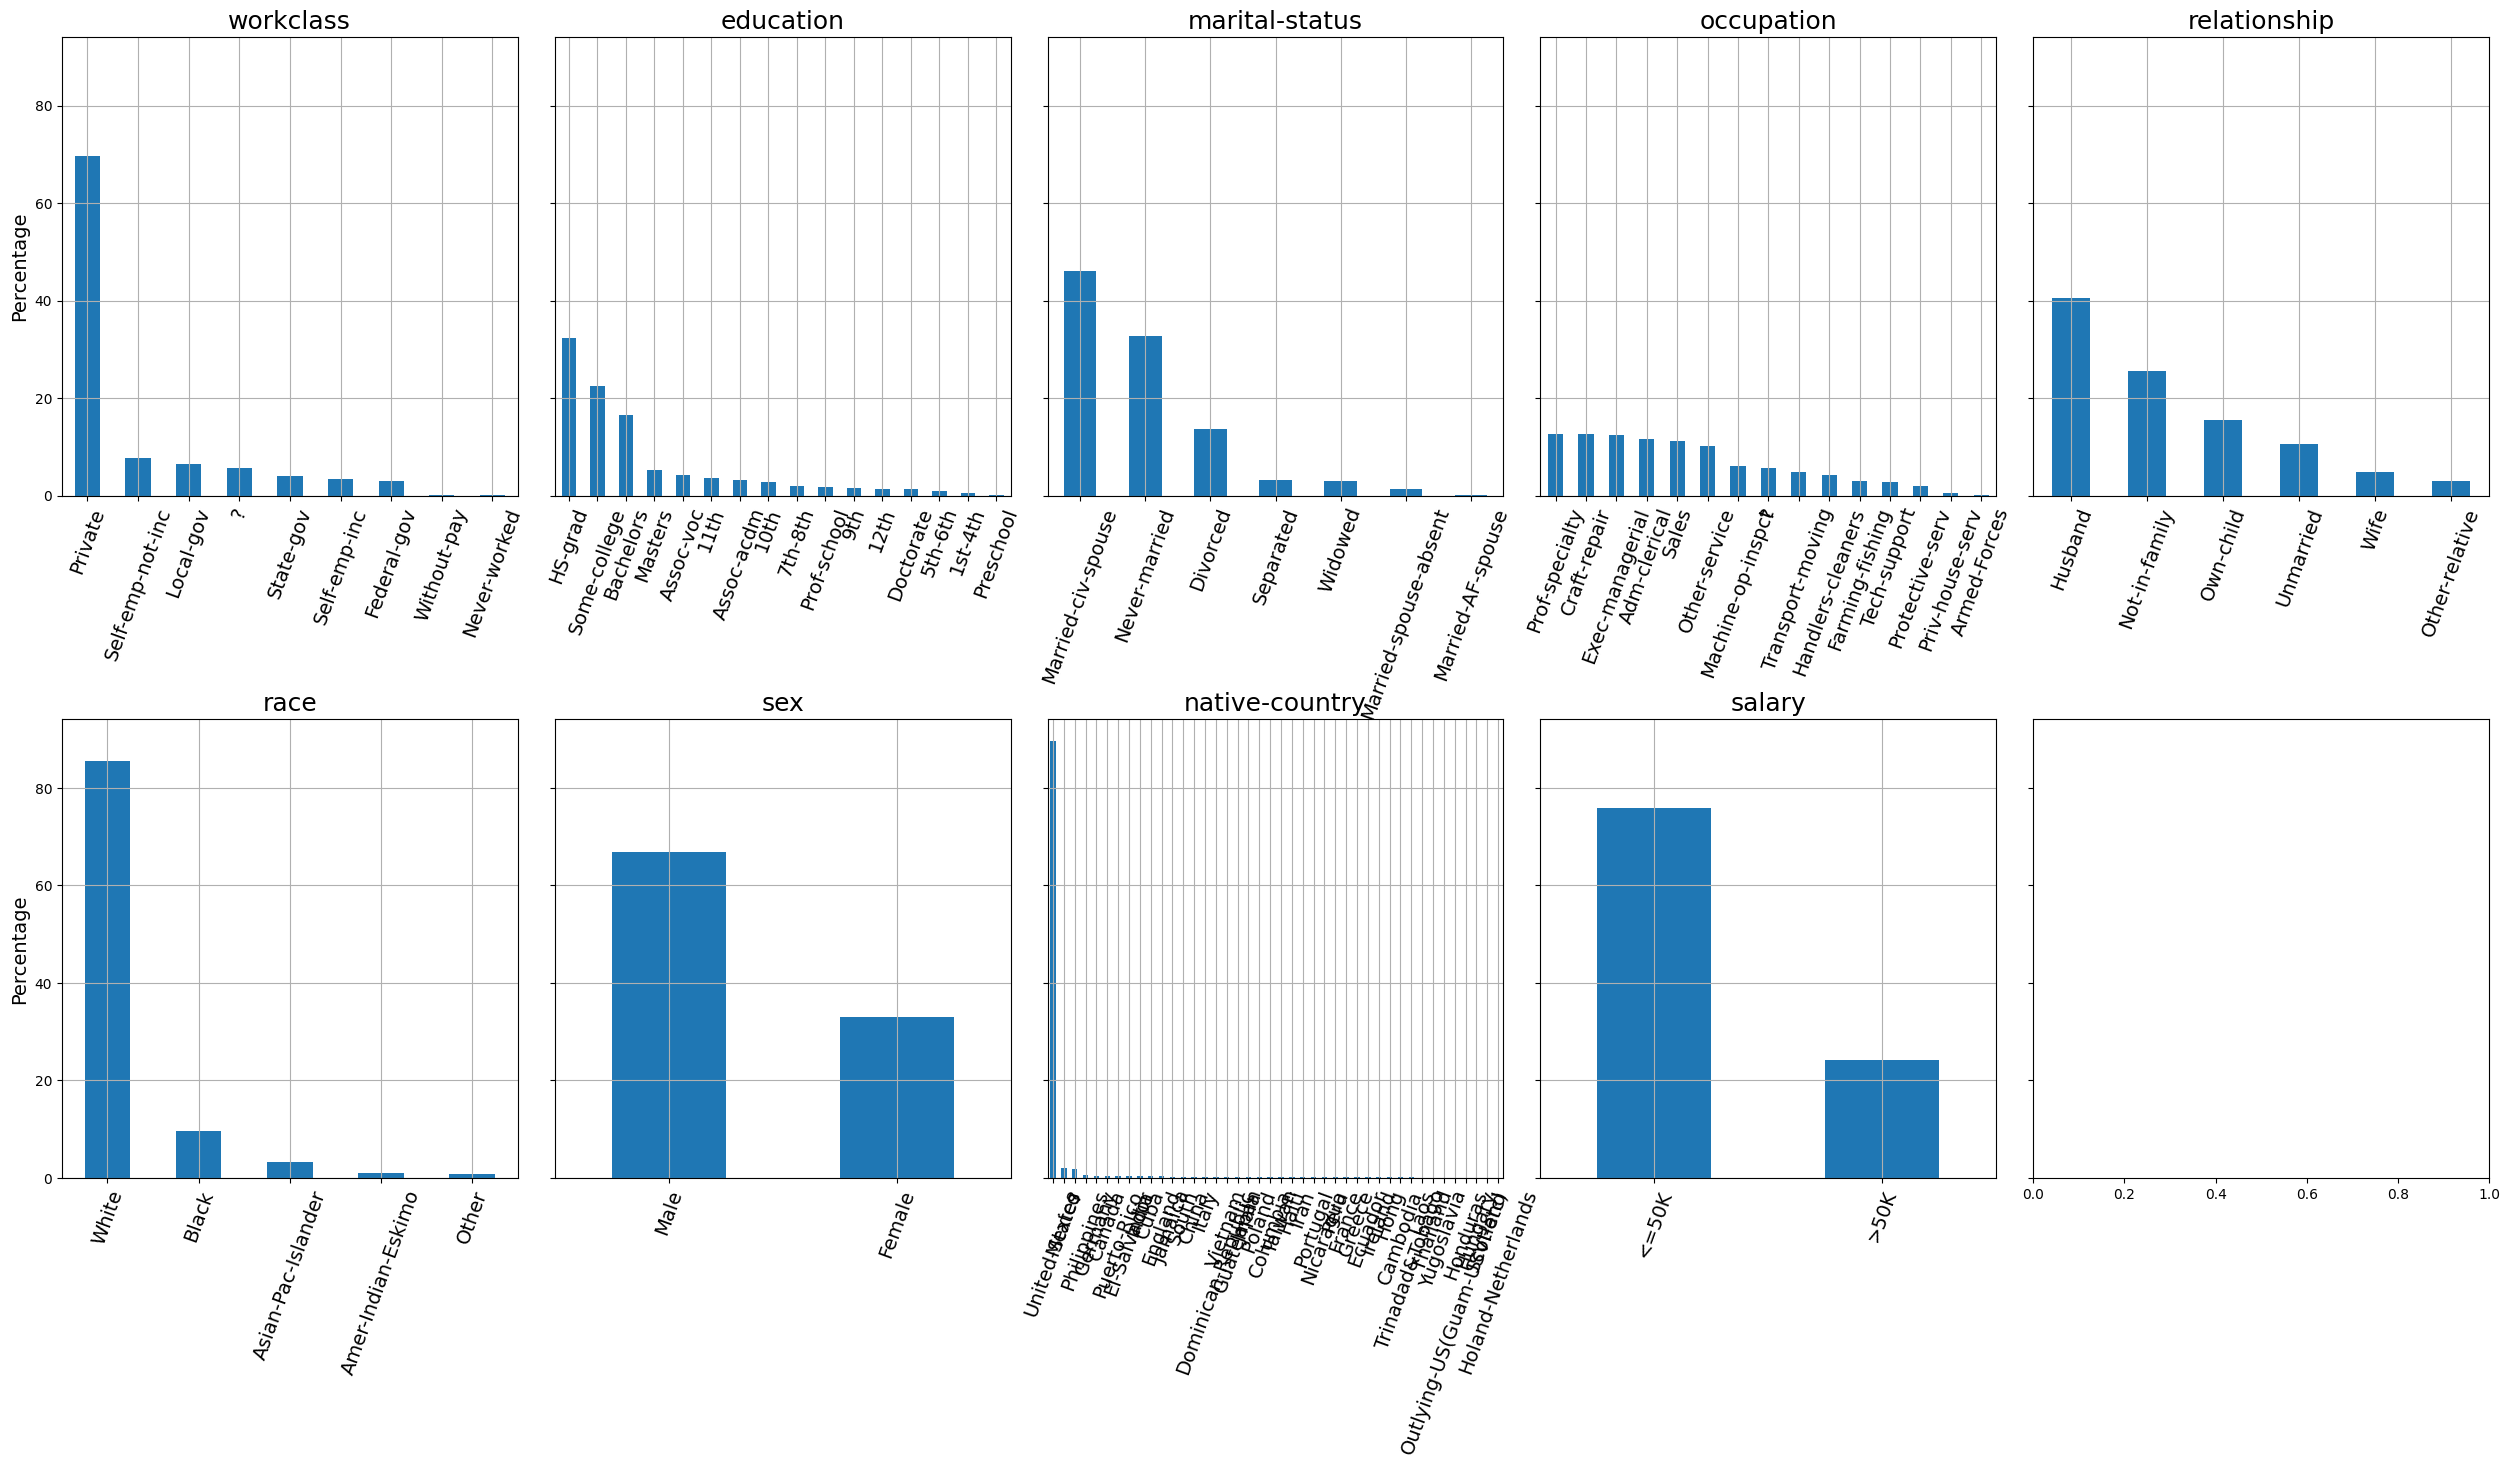

In [15]:
N = len(categorical_var)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var):
    i = int(n // K)
    j = int(n % K)
    feature_serie = train_df[col].value_counts()
    feature_serie_sum = feature_serie.sum()
    feature_serie_pct = feature_serie / feature_serie_sum * 100
    # print(feature_serie_pct)
    feature_serie_pct.plot.bar(ax=axes[i, j])
    axes[i, j].set_xticklabels(labels=feature_serie_pct.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].grid()

- First to note is the large unbalance (75/25) of the data labels "salary" .
- Then, one could possibly make the following assumptions:
  - The "native country" feature is largely dominated by the US. This is likely due to the fact that data has been collected in the USA and that people originating from other countr...  

### Similar data imbalance for both training and test datasets  

In [16]:
print("Training dataset:\n",round(train_df["salary"].value_counts(normalize=True),2))
print()
print("Testing dataset:\n",round(test_df["salary"].value_counts(normalize=True),2))

Training dataset:
 <=50K    0.76
>50K     0.24
Name: salary, dtype: float64

Testing dataset:
 <=50K    0.76
>50K     0.24
Name: salary, dtype: float64


### Display proportions of feature values for each label (<=50k vs  >50k) 

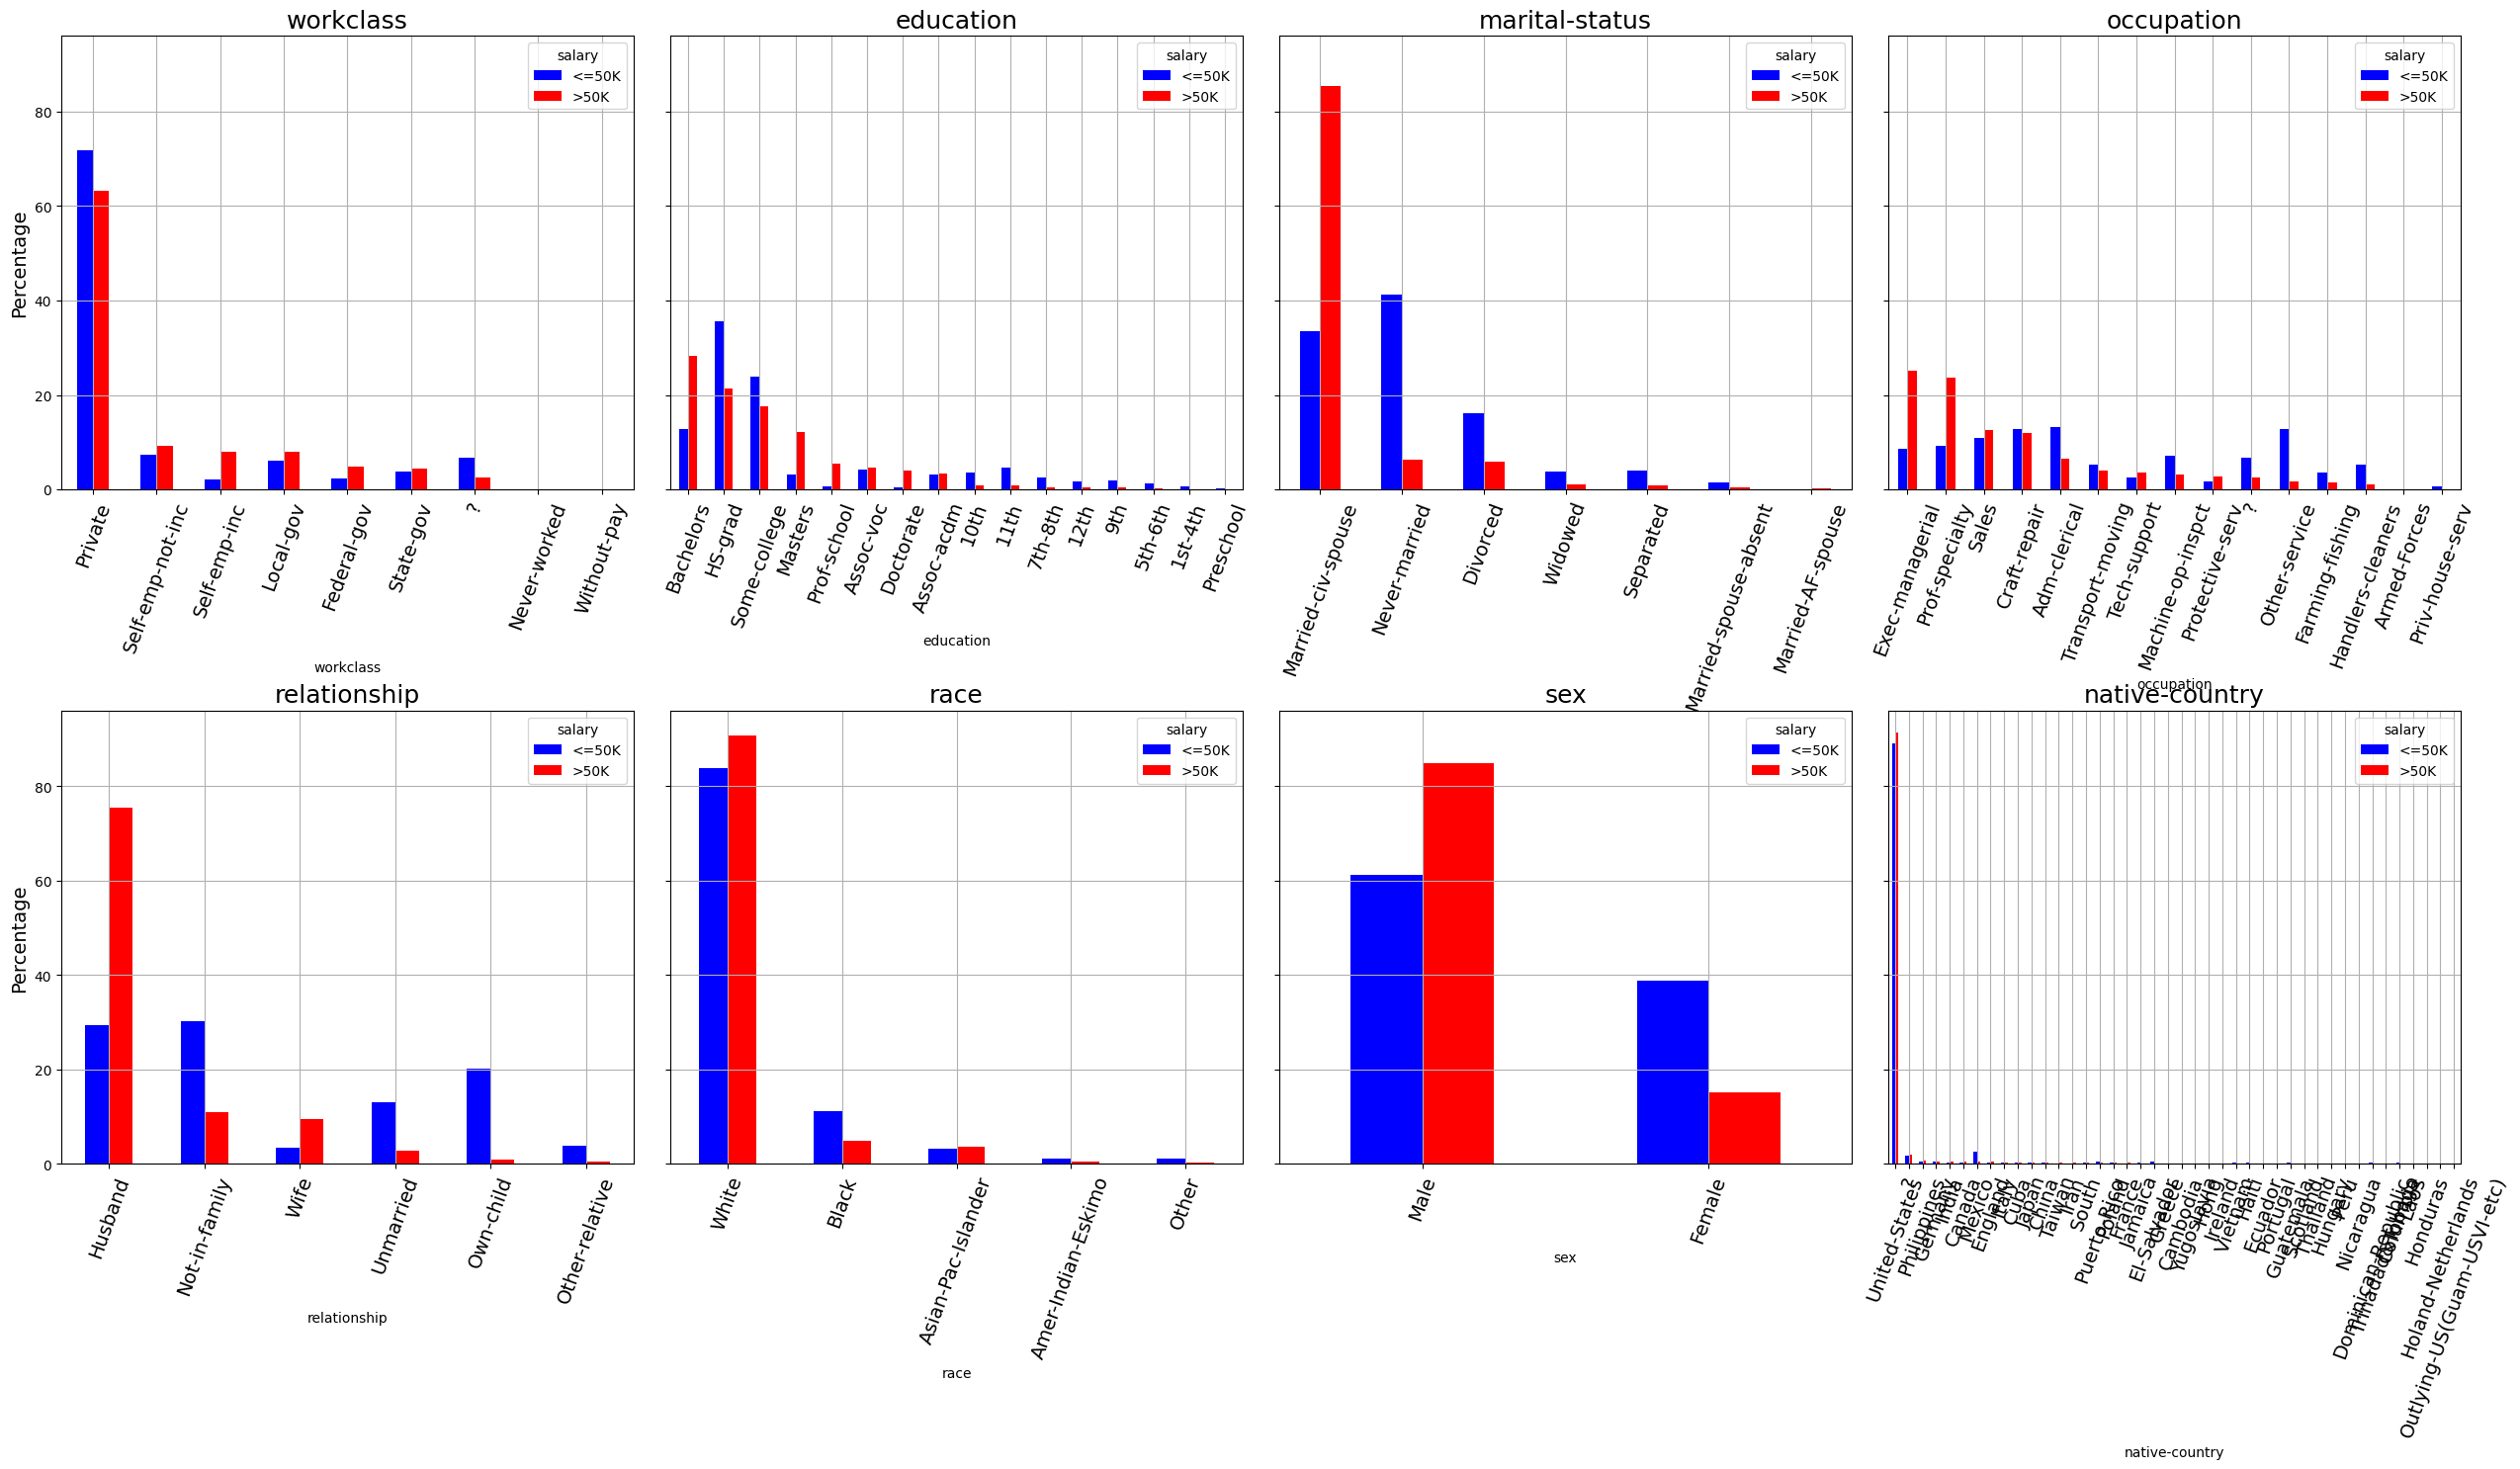

In [17]:
categorical_var_nosalary = categorical_var.copy()
categorical_var_nosalary.remove("salary")

N = len(categorical_var_nosalary)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var_nosalary):
    i = int(n // K)
    j = int(n % K)

    feature_ratio = pd.crosstab(train_df[col], train_df['salary'])
    feature_ratio_sum = feature_ratio.sum(axis= 0) # Use this to account for the unbalance dataset (pct considering each label independently)
    # feature_ratio_sum = train_df[col].value_counts().sum() # Use this to get the absolute proportion of feature values (biased towards <=50k due to unbalanced dataset)  
    feature_ratio_pct = feature_ratio / feature_ratio_sum * 100
    feature_ratio_pct_sorted = feature_ratio_pct.sort_values('>50K', ascending=[False])
    # print(feature_ratio_pct_sorted)
    
    feature_ratio_pct_sorted.plot.bar(ax=axes[i, j], color=["blue", "red"])
    axes[i, j].set_xticklabels(labels=feature_ratio_pct_sorted.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].grid()


The above plot shows the proportion of each feature values for each label class (">50k" vs "<50k") i.e add all blue bars (respectively red) to reach 100%.  
The data has been non-dimensionalized across the labels.   

We now would like to show the proportion of each label for each feature value i.e do the non-dimensionalization of data using feature values counts.  

### Display proportion of each label per categorical feature values

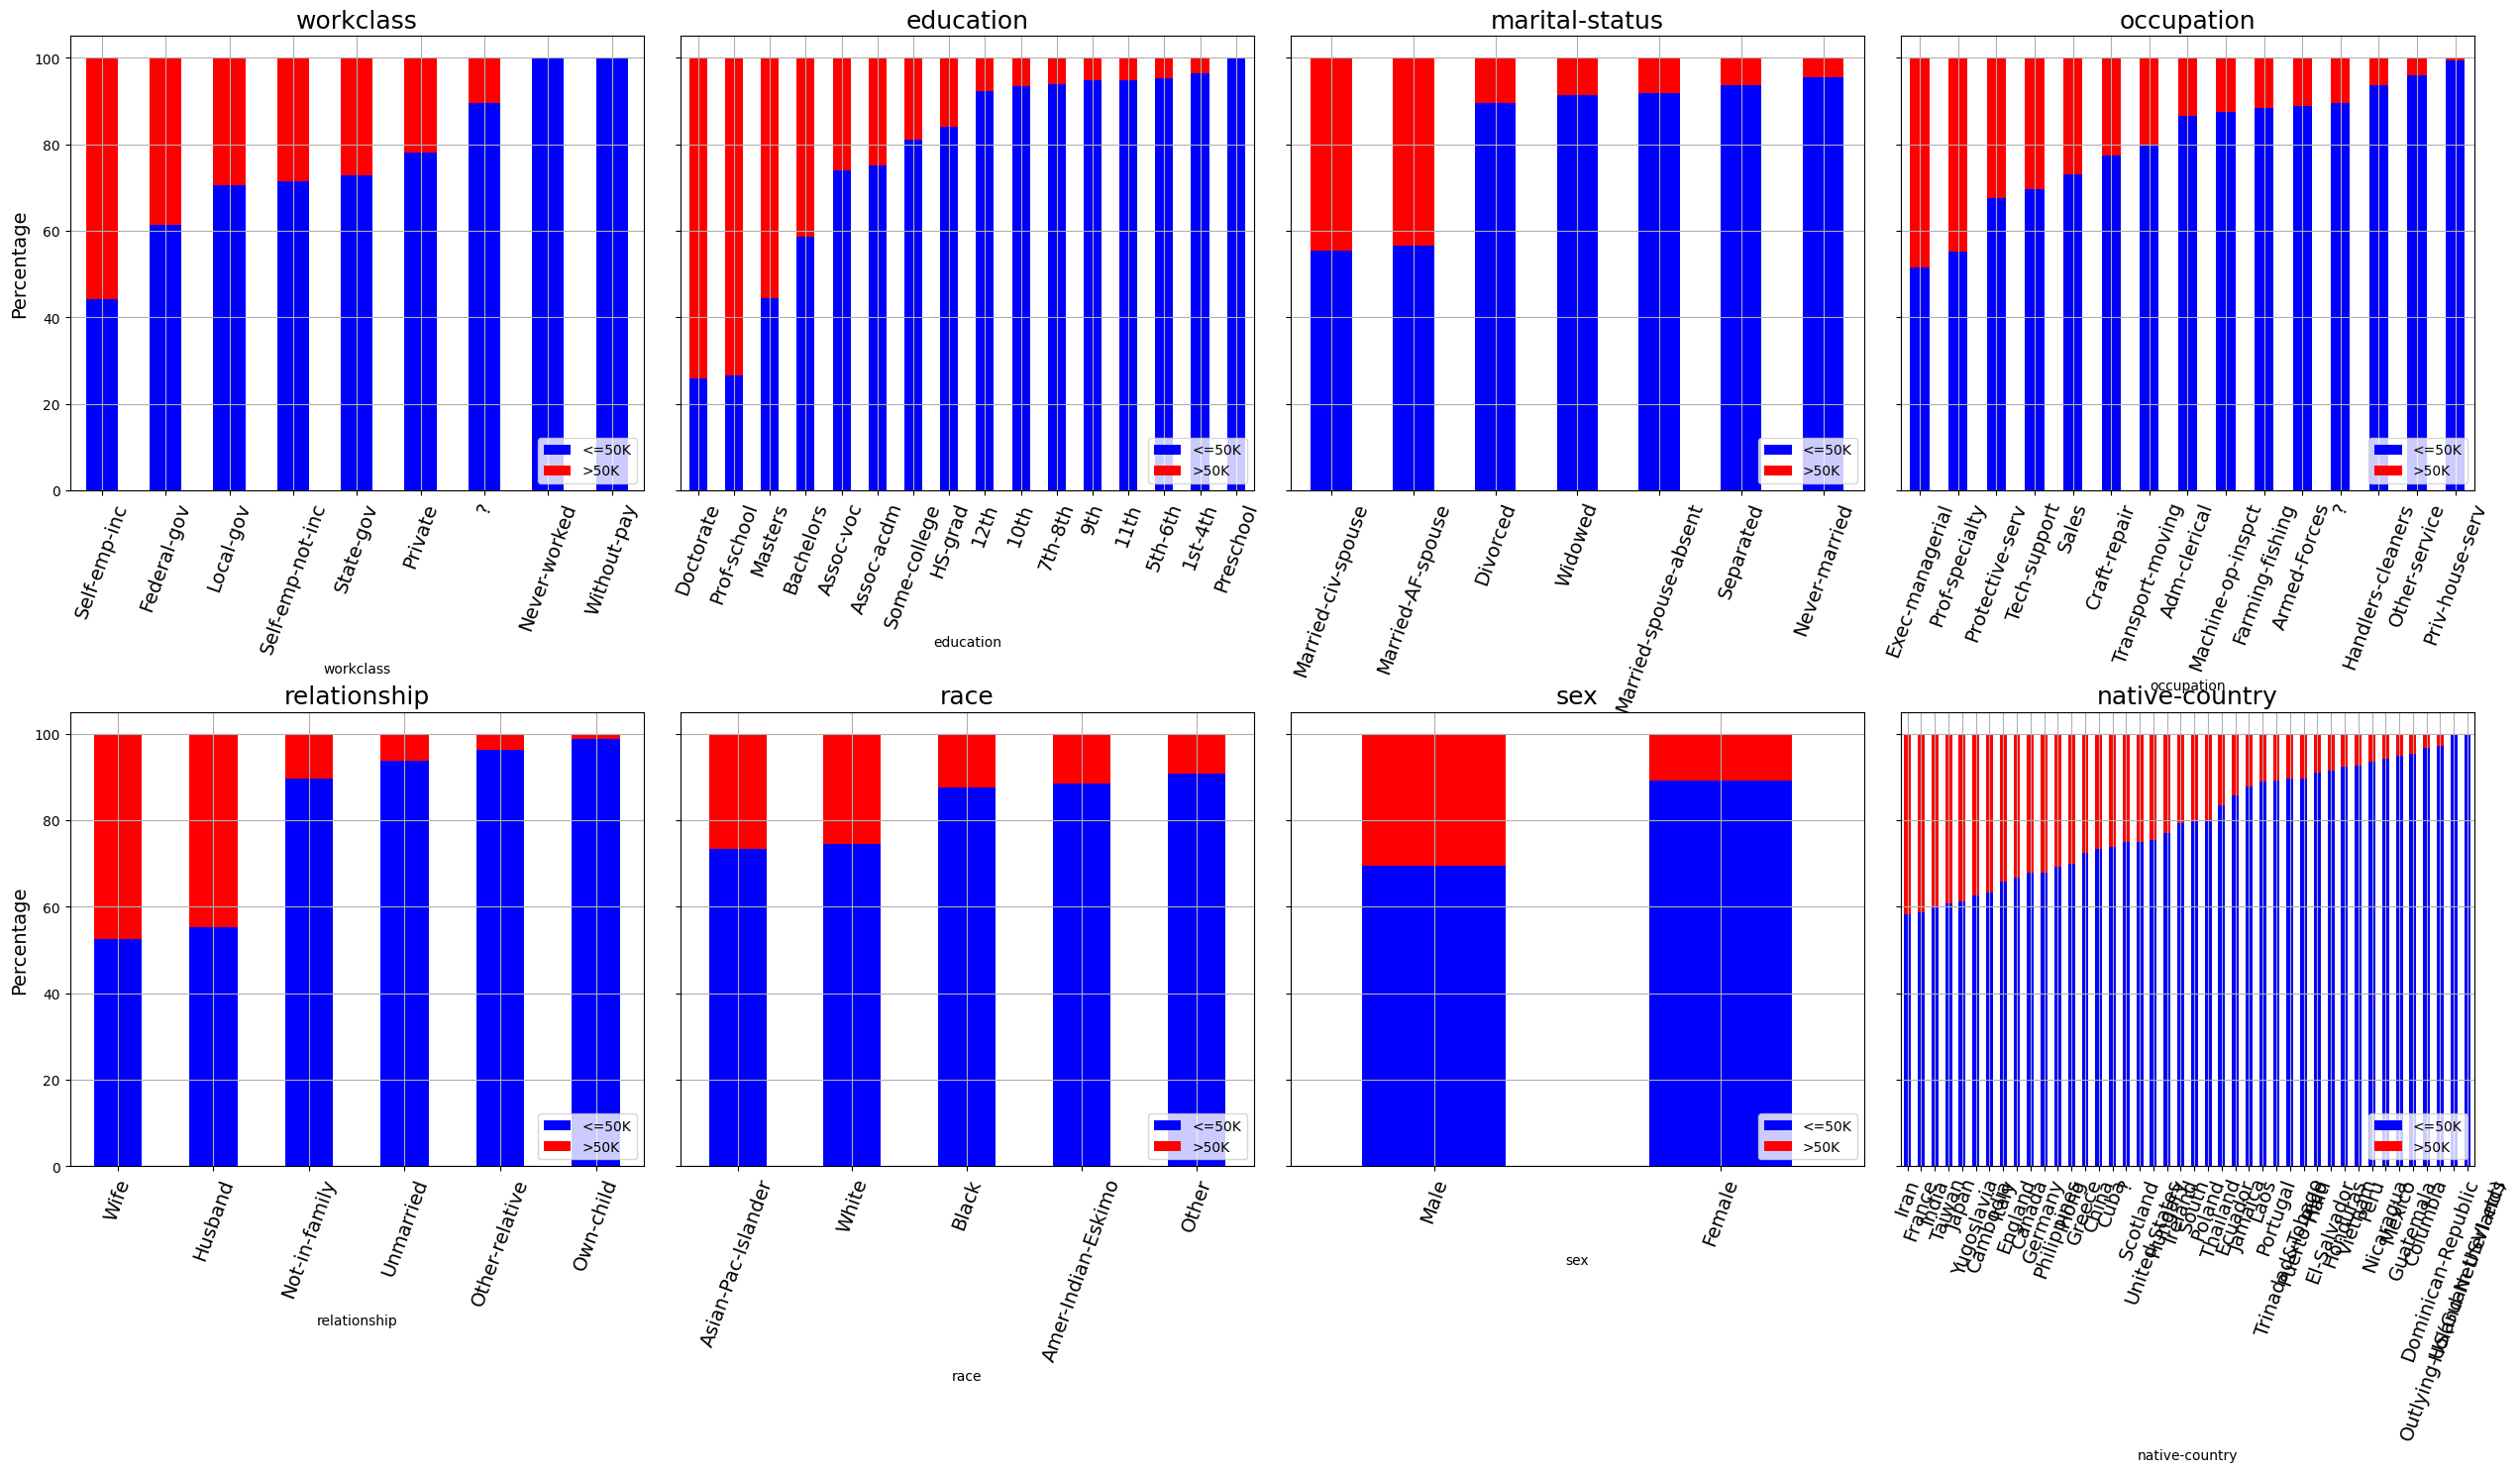

In [18]:
fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var_nosalary):
    i = int(n // K)
    j = int(n % K)

    feature_ratio = pd.crosstab(train_df[col], train_df['salary'])
    feature_ratio_sum = feature_ratio.sum(axis= 1) # NOW THE SUMMING IS DONE COLUMNS WISE
    feature_ratio_pct = (feature_ratio.T / feature_ratio_sum).T * 100
    feature_ratio_pct_sorted = feature_ratio_pct.sort_values('>50K', ascending=[False])
    # print(feature_ratio_pct_sorted)
    
    feature_ratio_pct_sorted.plot.bar(ax=axes[i, j], stacked = True, color=["blue", "red"])
    axes[i, j].set_xticklabels(labels=feature_ratio_pct_sorted.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].legend(loc='lower right')
    axes[i, j].grid()


Some interesting trends can be observed...
if follows that ..... blabla

### Data features correlation

Evaluating correlation matrix...


salary: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


done.


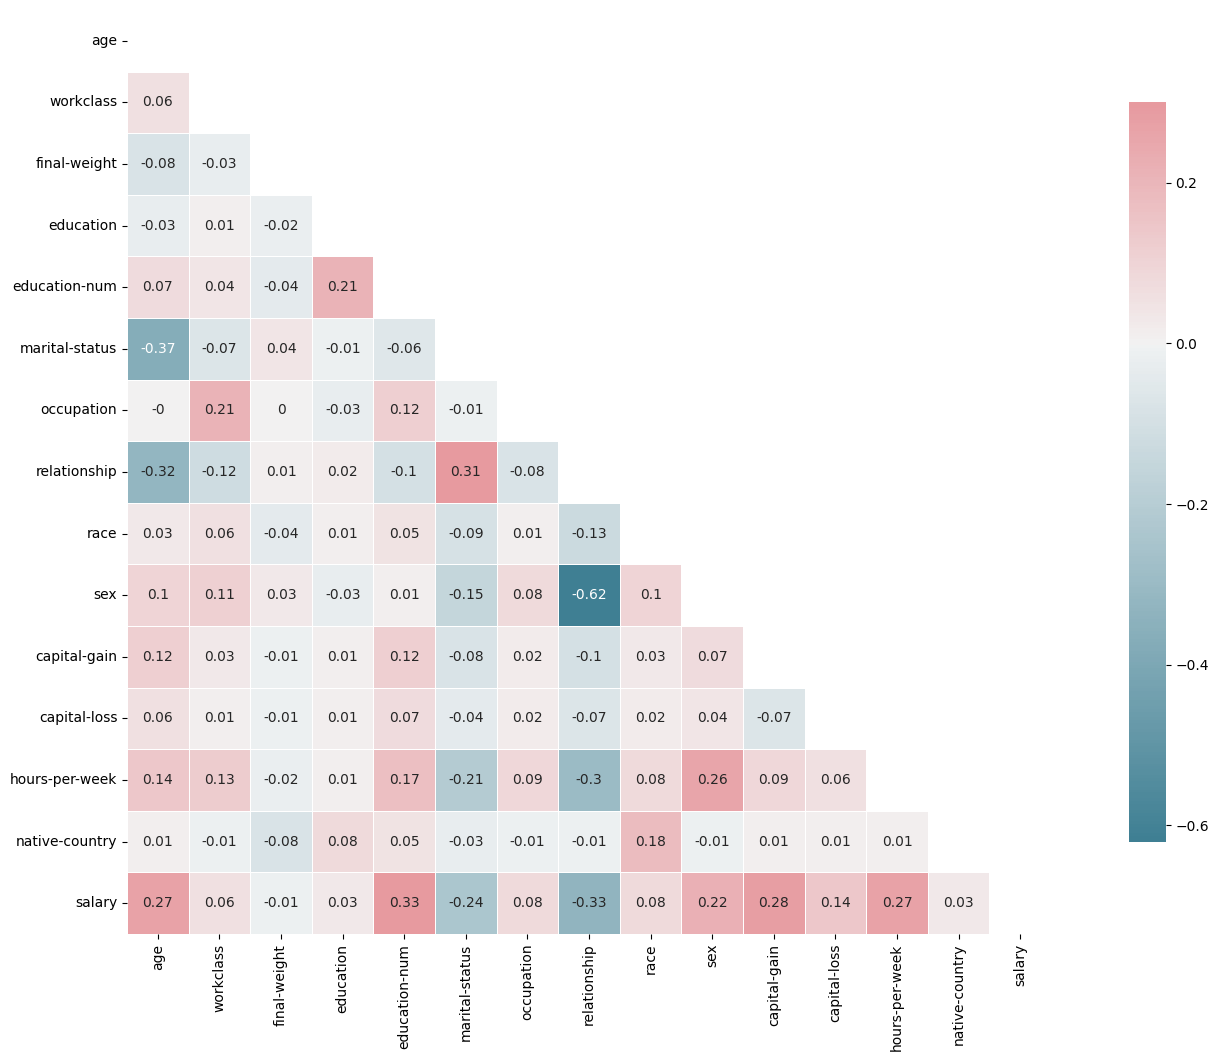

In [21]:
# Evaluation correlations
corr_matrix = evaluate_correlation(train_df)

# Generate a correlation matrix heat map
plot_correlation(corr_matrix)

Some interesting trends can be observed:   
- "education-num", "age", "capital-gain", "hours-per-week" and "sex" seem to have a HIGH POSITIVE correlation to "salary" == whereas == "marital-status", "relationship"have a HIGH NEGATIVE correlation to "salary". 
- On the contrary "workclass", "final-weight", "education(cat)", "occupation", "race", "capital-loss" and "native-country" seem to have a very LOW correlation to "salary".   

- Whereas some of the results for "age", "marital-status" (ie being in a couple) and "education-num" are VERY INTUITIVE whereas other results like "occupation" or "education(cat)" are somewhat COUNTER-INTUITIVE.     
- A puzzling result is the influence of "education-num" versus "education(categorical)". Although exactly the same meaning they have very different correlation with "salary".   

Let's investigate further... 

# 5. Data imbalance, data cleaning & feature engineering

The purpose of that section is to tackle the potential problems that may occur as a result of issues observed in the data exploration.

This should include:
- Data imbalance
- Data cleaning, replacing "?" values with the string "unknown" for instance 
- Feature selection and grouping if required
- Data transformation (encoding of categorical features, normalization of numerical features)
- Removal of redundant features

To be able to apply the same transformation to the test set we will use PIPELINE and COLUMNTRANSFORMER for all data transformation.

## 5.1. Imbalanced data

First we address the imbalance in the data using either SMOTE or OVERSAMPLING methods.   
**Warning**: this is only done on the training dataset only.

In [29]:
print("Data imbalance before correction: \n",np.round(pd.DataFrame(train_df["salary"].value_counts(normalize=True)*100),1) )

# METHOD 1: SMOTE
categorical_feature_mask = train_df.drop("salary", axis=1).dtypes == object
smote = SMOTENC (categorical_features = categorical_feature_mask, sampling_strategy="minority")
# X_balanced_df, y_balanced_df = smote.fit_sample(train_df.copy().drop("salary", axis=1), train_df["salary"]) # CONDA
X_balanced_df, y_balanced_df = smote.fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 2: OVER-SAMPLING
# ROS = RandomOverSampler() # random_state=30
# ROS.fit(train_df.copy().drop("salary", axis=1), train_df["salary"])
# X_balanced_df, y_balanced_df = ROS.fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

print()
print("Data imbalance after correction: \n",np.round(y_balanced_df.value_counts(normalize=True)*100, 1))

# Recombine X & y for ease of use in the Transform pipeline below
train_balanced_df = pd.concat([X_balanced_df, y_balanced_df], axis=1)
# train_balanced_df.sample(frac=1).head()
train_balanced_df.tail()

Data imbalance before correction: 
        salary
<=50K  75.9  
>50K   24.1  

Data imbalance after correction: 
 <=50K    50.0
>50K     50.0
Name: salary, dtype: float64


,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
49435,36,Private,242036,Bachelors,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,46,United-States,>50K
49436,46,Private,147289,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
49437,59,Private,232276,Bachelors,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
49438,43,Private,208840,HS-grad,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
49439,43,Private,174430,HS-grad,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K


We now have 49'439 samples in the training dataset (instead of 32'560).

Evaluating correlation matrix...


salary: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


done.


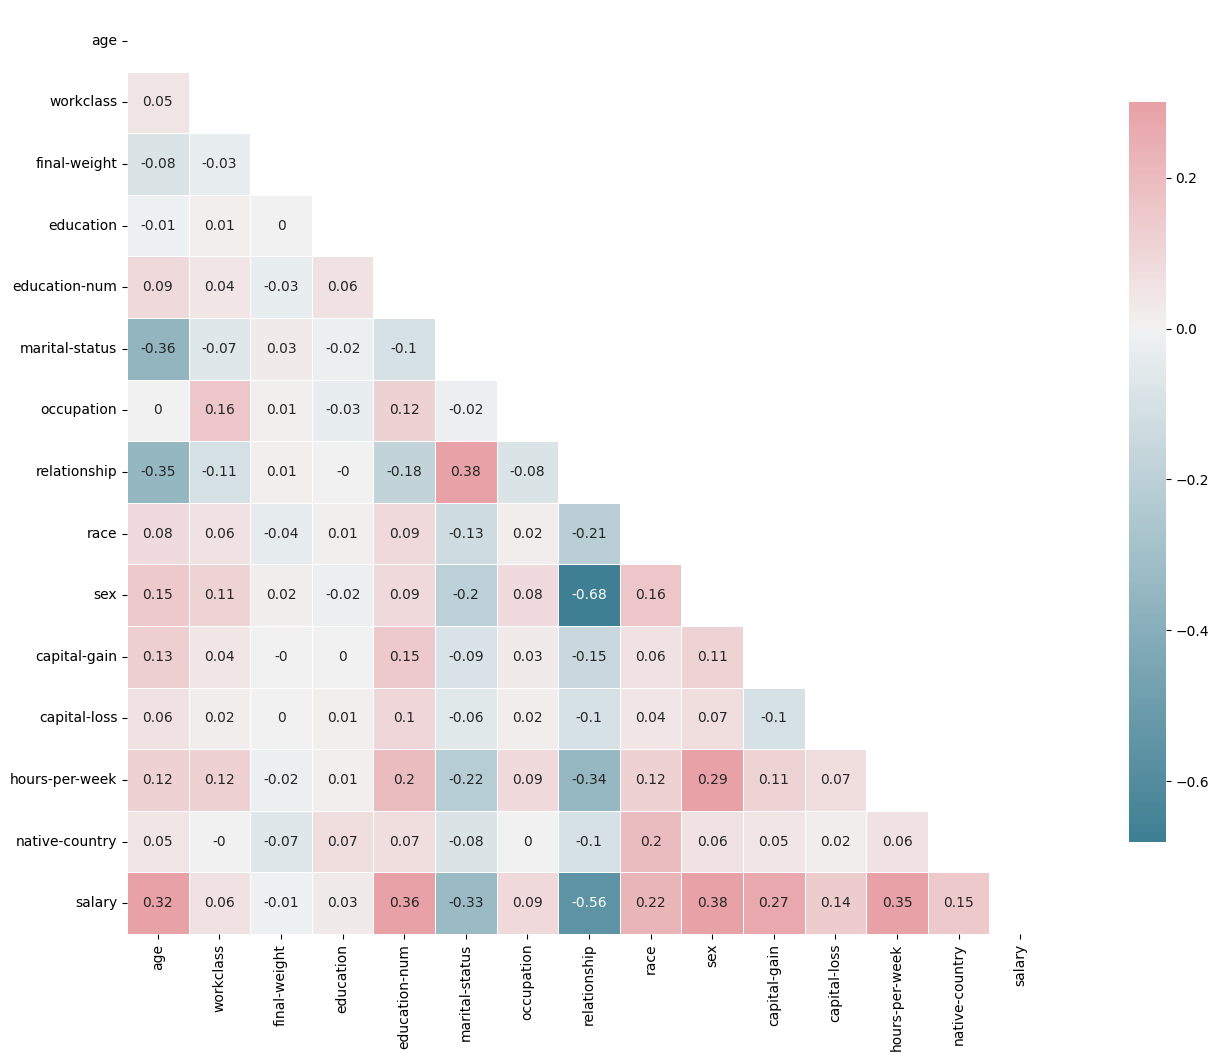

In [30]:
# Evaluation correlations
corr_matrix = evaluate_correlation(train_balanced_df)

# Generate a correlation matrix heat map
plot_correlation(corr_matrix)

After sorting the data imbalance we can see that:   

- "relationship" and "marital-status" have an even stronger negative correlation to "salary".    
- "sex", "education-num", "hours-per-week" have slightly gained in positive correlation to "salary".    

- the most striking results is that "race", "sex" and "native-country"'s correlation to "salary" have sharply increased. A possible explaination is that they were massively under represented in the original data (or that SMOTE has over represented them).   
- As previously noted "workclass", "final-weight", "education(cat)" and "occupation" seem to have a very LOW correlation to "salary".   

Let's 


## 5.2. Data transformation, feature value groups

### Grouping feature values

Based on observations from the data exploration above we want to group values within each categorical features to reduce the number variables in our model and improve the effectiveness of the model algorithm.  

we noticed that some values within each categorical feature have similar proportion with regard to the dependent variable (Salary). Those values can be grouped under the assumption they have the same influence on the dependent variable.   

**Note:** As mentioned above we want to PIPELINE  all transformations to be able to apply the same transformations to the test set so we are only defining the groups here.   
- Basically a list of values is grouped into a new variable for each categorical feature.     
- Then a dictionnary is created including 2 keys: (1) the group name and (2) the list of feature values to be grouped.   
- A customer transformer will automatically apply the grouping (see GroupFeatureValues_CT in Helper function section).   
 

In [32]:
CAT_FEATS_GROUP = {}

###  education: { Preschool, 1st-4th,  5th-6th, 7th-8th,  9th, 10th, 11th, 12th, HS-grad, Assoc-voc, Some-college, Bachelors,  Masters,  Prof-school, Assoc-acdm, Doctorate} 
elem_school = ['Preschool', '1st-4th','5th-6th']
mid_school = ['7th-8th' ]
high_school_lower = ['9th','10th','11th','12th']
high_school_upper = ['HS-grad', 'Assoc-voc', 'Assoc-acdm', 'Some-college',]
graduate = ['Bachelors', 'Masters']
post_grad = ['Prof-school', 'Doctorate']

CAT_FEATS_GROUP["education"] = {"elem_school":elem_school, "mid_school":mid_school, "high_school_lower":high_school_lower, "high_school_upper":high_school_upper, 
                  "graduate":graduate, "post_grad":post_grad}
education_rank = [["elem_school", "mid_school", "high_school_lower", "high_school_upper", "graduate", "post_grad"]]

##  workclass: {nan, Self-emp-not-inc, Local-gov, Federal-gov, Self-emp-inc, Without-pay, Private, State-gov, Never-worked}                                                                                                                                                                                                                                                                                                                         
self_employed_expert = ['Self-emp-inc']
self_employed = ['Self-emp-not-inc', "Private"]
public_servant = ['Local-gov','State-gov','Federal-gov']
unemployed = ["Without-pay", "Never-worked"]

CAT_FEATS_GROUP["workclass"] = {"self_employed_expert":self_employed_expert,"self_employed":self_employed, "public_servant":public_servant, "unemployed":unemployed}

### occupation: {nan, Sales, Farming-fishing, Machine-op-inspct, Craft-repair, Transport-moving, Protective-serv, Priv-house-serv, Other-service, Prof-specialty, Exec-managerial, 
#  Armed-Forces, Handlers-cleaners, Adm-clerical, Tech-support}

executives = ["Prof-specialty", "Exec-managerial"]
experts = ["Protective-serv", "Tech-support", "Sales", "Craft-repair", "Transport-moving"]
technicians = ["Adm-clerical", "Machine-op-inspct", "Farming-fishing", "Armed-Forces"]
services = ["Priv-house-serv", "Other-service", "Handlers-cleaners"]

CAT_FEATS_GROUP["occupation"] =  {"executives":executives, "experts":experts, "technicians":technicians, "services":services}

### marital-status: {Widowed, Married-civ-spouse, Married-spouse-absent, Divorced, Separated, Married-AF-spouse, Never-married}          
couple = ['Married-civ-spouse','Married-AF-spouse']
single = ['Separated','Divorced', 'Married-spouse-absent', 'Widowed', 'Never-married']

CAT_FEATS_GROUP["marital-status"] =  {"couple":couple, "single":single}

### relationship: {Unmarried, Not-in-family, Wife, Other-relative, Husband, Own-child}  
family_strong = ["Wife", "Husband"]
family_weak = ["Other-relative", "Own-child"]
family_none = ["Unmarried", "Not-in-family"] 

CAT_FEATS_GROUP["relationship"] =  {"family_strong":family_strong, "family_weak":family_weak, "family_none":family_none}

## native-country
# GDP info: https://statisticstimes.com/economy/countries-by-projected-gdp-capita.php

# countries with GDP/capita >40kUSD
GDP_high = ["France",  "Ireland",  "United-States",  "Holand-Netherlands",  "Canada",  "Germany",  "Hong",  "England",  "Japan",  "Scotland"] 
# countries with GDP/capita <20kUSD
GDP_mid  = ["Italy",  "South",  "Puerto-Rico",  "Taiwan",  "Portugal", "Greece", "Hungary", "Poland", "Trinadad&Tobago", "China"]
# countries with GDP/capita <10kUSD
GDP_low = ["Mexico", "Dominican-Republic", "Thailand", "Peru", "Columbia", "Ecuador", "Jamaica", "Guatemala", "El-Salvador", "Vietnam", "Philippines", "Laos", "Honduras", "India", 
           "Nicaragua", "Haiti", "Cambodia", "Iran", "Yugoslavia", "Outlying-US(Guam-USVI-etc)", "Cuba"] 

CAT_FEATS_GROUP["native-country"] =  {"GDP_high":GDP_high, "GDP_mid":GDP_mid, "GDP_low":GDP_low}

#### Overview
print("Categorical features which were grouped:", CAT_FEATS_GROUP.keys())


Categorical features which were grouped: dict_keys(['education', 'workclass', 'occupation', 'marital-status', 'relationship', 'native-country'])


### Removing redundant features
Finally we want to remove redundant features.    

This is done automatically in the pipeline below by NOT CALLING the redundent specific feature(s).   

The pipeline below wil allow to easily combine or remove features thought to have little correlation with "salary".

Let's first review the building of the transformation pipeline.

## 5.3 Data transformation using customer transformers - detailed

Different feature variables require different transformations, even within the categorical variables set.  

In order to make the data transformation easily understandable we will breakdown transformations separately and use Custom Transformers to output pandas DataFrame.   
This will hopefully help follow and understand each transformation.

In [33]:
VERBOSE = True

CAT_FEATS_ORDINAL = ["education"]
CAT_FEATS_ORDINAL_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_ORDINAL]

pipe1 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_ORDINAL)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('group feature values', GroupFeatureValues_CT(CAT_FEATS_ORDINAL_DICT)),
                        ('Ordinal encoding', OrdinalEncoder_CT(categories=education_rank)),
                        ], verbose=VERBOSE)

df1 = pipe1.fit_transform(train_balanced_df)
df1.head()

[Pipeline] ........... (step 1 of 4) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 4) Processing Replace ?, total=   0.0s
[Pipeline]  (step 3 of 4) Processing group feature values, total=   0.0s
[Pipeline] .. (step 4 of 4) Processing Ordinal encoding, total=   0.0s


,education
0,4.0
1,4.0
2,3.0
3,2.0
4,4.0


In [34]:
CAT_FEATS_OHE = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']
CAT_FEATS_OHE_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_OHE]

pipe2 = Pipeline(steps=[('columns extraction', ColumnExtractor_CT(CAT_FEATS_OHE)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('feature values grouping', GroupFeatureValues_CT(CAT_FEATS_OHE_DICT)),
                        ('OHE', OHE_CT(CAT_FEATS_OHE)),
                        ], verbose=VERBOSE)

df2 = pipe2.fit_transform(train_balanced_df)
df2.head()

[Pipeline]  (step 1 of 4) Processing columns extraction, total=   0.0s
[Pipeline] ......... (step 2 of 4) Processing Replace ?, total=   0.0s
[Pipeline]  (step 3 of 4) Processing feature values grouping, total=   0.2s
[Pipeline] ............... (step 4 of 4) Processing OHE, total=   0.1s


,workclass.public_servant,workclass.self_employed,workclass.self_employed_expert,workclass.unemployed,workclass.unknown,marital-status.couple,marital-status.single,occupation.executives,occupation.experts,occupation.services,occupation.technicians,occupation.unknown,relationship.family_none,relationship.family_strong,relationship.family_weak,native-country.GDP_high,native-country.GDP_low,native-country.GDP_mid,native-country.unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [35]:
CAT_FEATS_LBIN = ['salary','sex']
# CAT_FEATS_LBIN = ['sex']

pipe3 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_LBIN)),
                        ('OHE', ColumnsLabelBinarizer_CT()),
                        ], verbose=VERBOSE)

df3 = pipe3.fit_transform(train_balanced_df)
df3.head(10)

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing OHE, total=   0.3s


,salary,sex
0,0,1
1,0,1
2,0,1
3,0,1
4,0,0
5,0,0
6,0,0
7,1,1
8,1,0
9,1,1


In [36]:
CAT_FEATS_DUMMIES = ['race']

pipe4 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_DUMMIES)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('OHE', GetDummies_CT()),
                        ], verbose=VERBOSE)

df4 = pipe4.fit_transform(train_balanced_df)
df4.head()

[Pipeline] ........... (step 1 of 3) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 3) Processing Replace ?, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing OHE, total=   0.3s


,race=Amer-Indian-Eskimo,race=Asian-Pac-Islander,race=Black,race=Other,race=White
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [37]:
NUM_FEATS_STDSCAL = ['hours-per-week', 'capital-gain', 'capital-loss']

pipe5 = Pipeline(steps=[('extract', ColumnExtractor_CT(NUM_FEATS_STDSCAL)),
                        ('StdScaler', StdScaler_CT()),
                        ], verbose=VERBOSE)

df5 = pipe5.fit_transform(train_balanced_df)
df5.head()

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing StdScaler, total=   0.0s


,hours-per-week,capital-gain,capital-loss
0,-0.182491,0.007892,-0.257932
1,-2.529103,-0.196057,-0.257932
2,-0.182491,-0.196057,-0.257932
3,-0.182491,-0.196057,-0.257932
4,-0.182491,-0.196057,-0.257932


In [38]:
NUM_FEATS_MINMAX=['age']

pipe6 = Pipeline(steps=[('extract', ColumnExtractor_CT(NUM_FEATS_MINMAX)),
                        ('MinMaxScaler', MinMaxScaler_CT(NUM_FEATS_MINMAX)),
                        ], verbose=VERBOSE)

df6 = pipe6.fit_transform(train_balanced_df)
df6.head()

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing MinMaxScaler, total=   0.0s


,age
0,0.301370
1,0.452055
2,0.287671
3,0.493151
4,0.150685


### Vizualize the whole transformation pipeline using ColumnTransformer 

We can use ColumnTransformer to vizulize all the pipeline transformations above and even pipe a classification model after the transformation.


In [39]:
preprocessing = ColumnTransformer([
                                    ("categorical Ordinal", pipe1, CAT_FEATS_ORDINAL),
                                    ("categorical OHE", pipe2, CAT_FEATS_OHE),
                                    ("categorical LabelBin", pipe3, CAT_FEATS_LBIN),
                                    ("categorical Dummies", pipe4, CAT_FEATS_DUMMIES),
                                    ("numerical StdScaler", pipe5, NUM_FEATS_STDSCAL),
                                    ("numerical MinMaxScaler", pipe6, NUM_FEATS_MINMAX),
                                ])

model = Pipeline(steps=[ ("preprocessing",preprocessing), 
                        ("Model", Model_CT(LogisticRegression())),
                    ])

model  # Click on the small arrows in the diagram below to expand the pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical Ordinal',
                                                  Pipeline(steps=[('extract',
                                                                   <__main__.ColumnExtractor_CT object at 0x7fae43631d60>),
                                                                  ('Replace ?',
                                                                   FunctionTransformer(func=<function replace_value at 0x7fae490a1e50>,
                                                                                       kw_args={'to_replace': '?',
                                                                                                'value': 'unknown'})),
                                                                  ('group '
                                                                   'feature '
                                                                   'values',
                                                                   GroupFeatureValues_CT(features_di...
                                                                   StdScaler_CT(columns=['hours-per-week',
                                                                                         'capital-gain',
                                                                                         'capital-loss']))],
                                                           verbose=True),
                                                  ['hours-per-week',
                                                   'capital-gain',
                                                   'capital-loss']),
                                                 ('numerical MinMaxScaler',
                                                  Pipeline(steps=[('extract',
                                                                   <__main__.ColumnExtractor_CT object at 0x7fae43725190>),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler_CT(columns=['age']))],
                                                           verbose=True),
                                                  ['age'])])),
                ('Model', Model_CT(model=LogisticRegression()))])

Unfortunately the ColumnTransformer automatically outpus numpy arrays which makes the vizualization of the transformed dataset more difficult and cumbersome.   
We will therefore go for a pipeline instead which, used in combination with CustomerTransformers, can output the data transformation as a pandas Dataframe.  

## 5.4 Dataset transform (as pandas dataframe) - compact

All the above transformations can be integrated in one large pipeline.   

In [40]:
CAT_FEATS_ORDINAL = ["education"]
CAT_FEATS_ORDINAL_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_ORDINAL]
CAT_FEATS_OHE = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']
CAT_FEATS_OHE_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_OHE]
CAT_FEATS_LBIN = ['sex', 'salary']
CAT_FEATS_DUMMIES = ['race']
NUM_FEATS_STDSCAL = ['hours-per-week', 'capital-gain', 'capital-loss']
NUM_FEATS_MINMAX=['age']

VERBOSE = False

full_pipe_df = Pipeline([ ('Feats', FeatureUnion_CT([ 
                                                    ("categorical Ordinal", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_ORDINAL)),
                                                                                      ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                                                                      ('group feature values', GroupFeatureValues_CT(CAT_FEATS_ORDINAL_DICT )),
                                                                                      ('Ordinal encoding', OrdinalEncoder_CT(categories=education_rank)),
                                                                                     ], verbose=VERBOSE), CAT_FEATS_ORDINAL),
                                                    ("categorical OHE", Pipeline([('columns extraction', ColumnExtractor_CT(CAT_FEATS_OHE)),
                                                                                ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                                                                ('feature values grouping', GroupFeatureValues_CT(CAT_FEATS_OHE_DICT)),
                                                                                ('OHE', OHE_CT(CAT_FEATS_OHE)),
                                                                                ], verbose=VERBOSE), CAT_FEATS_OHE),
                                                    ("categorical LabelBin", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_LBIN)),
                                                                                     ('OHE', ColumnsLabelBinarizer_CT()),
                                                                                    ], verbose=VERBOSE), CAT_FEATS_LBIN),
                                                    ("categorical Dummies", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_DUMMIES)),
                                                                                    ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                                                                    ('OHE', GetDummies_CT()),
                                                                                    ], verbose=VERBOSE), CAT_FEATS_DUMMIES),
                                                    ("numerical StdScaler", Pipeline([('extract', ColumnExtractor_CT(NUM_FEATS_STDSCAL)),
                                                                                      ('StdScaler', StdScaler_CT()),
                                                                                     ], verbose=VERBOSE), NUM_FEATS_STDSCAL),
                                                    ("numerical MinMaxScaler", Pipeline([('extract', ColumnExtractor_CT(NUM_FEATS_MINMAX)),
                                                                                         ('MinMaxScaler', MinMaxScaler_CT(NUM_FEATS_MINMAX)),
                                                                                        ], verbose=VERBOSE), NUM_FEATS_MINMAX),                                             
                                                    ]),
                          ),
                        ])

full_pipe_df  # Click on the small arrows in the diagram below to expand the pipeline

Pipeline(steps=[('Feats',
                 FeatureUnion_CT(transformer_list=[('categorical Ordinal',
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7fae408a1550>),
                                                                    ('Replace '
                                                                     '?',
                                                                     FunctionTransformer(func=<function replace_value at 0x7fae490a1e50>,
                                                                                         kw_args={'to_replace': '?',
                                                                                                  'value': 'unknown'})),
                                                                    ('group '
                                                                     'feature '
                                                                     'values',
                                                                     GroupFeatureValues_CT(features_dict_l...
                                                                    ('OHE',
                                                                     <__main__.GetDummies_CT object at 0x7fae435875e0>)])),
                                                   ('numerical StdScaler',
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7fae435874f0>),
                                                                    ('StdScaler',
                                                                     StdScaler_CT())])),
                                                   ('numerical MinMaxScaler',
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7fae43587820>),
                                                                    ('MinMaxScaler',
                                                                     MinMaxScaler_CT(columns=['age']))]))]))])

We are now ready to transform the training dataset using the pipeline created.

In [41]:
# training_dataset = full_pipe_df.fit_transform(train_df)
training_dataset = full_pipe_df.fit_transform(train_balanced_df)
training_dataset.tail()

,education,workclass.public_servant,workclass.self_employed,workclass.self_employed_expert,workclass.unemployed,workclass.unknown,marital-status.couple,marital-status.single,occupation.executives,occupation.experts,occupation.services,occupation.technicians,occupation.unknown,relationship.family_none,relationship.family_strong,relationship.family_weak,native-country.GDP_high,native-country.GDP_low,native-country.GDP_mid,native-country.unknown,sex,salary,race=Amer-Indian-Eskimo,race=Asian-Pac-Islander,race=Black,race=Other,race=White,hours-per-week,capital-gain,capital-loss,age
49435,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,0.338978,-0.196057,-0.257932,0.260274
49436,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,-0.182491,-0.196057,-0.257932,0.397260
49437,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,0.252066,-0.196057,-0.257932,0.575342
49438,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,-0.182491,-0.196057,-0.257932,0.356164
49439,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,-0.182491,-0.196057,-0.257932,0.356164


And similarly for the test dataset

In [42]:
test_dataset = full_pipe_df.fit_transform(test_df)
test_dataset.tail()

,education,workclass.public_servant,workclass.self_employed,workclass.self_employed_expert,workclass.unemployed,workclass.unknown,marital-status.couple,marital-status.single,occupation.executives,occupation.experts,occupation.services,occupation.technicians,occupation.unknown,relationship.family_none,relationship.family_strong,relationship.family_weak,native-country.GDP_high,native-country.GDP_low,native-country.GDP_mid,native-country.unknown,sex,salary,race=Amer-Indian-Eskimo,race=Asian-Pac-Islander,race=Black,race=Other,race=White,hours-per-week,capital-gain,capital-loss,age
16276,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,-0.351972,-0.142662,-0.218062,0.301370
16277,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0.0,0.0,1.0,0.0,0.0,-0.031432,-0.142662,-0.218062,0.643836
16278,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0,0.769918,-0.142662,-0.218062,0.287671
16279,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0,-0.031432,0.576644,-0.218062,0.369863
16280,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,1.571267,-0.142662,-0.218062,0.246575


## 5.5 Final features selection

Evaluating correlation matrix...


salary: 100%|██████████| 31/31 [00:00<00:00, 146.30it/s]


done.


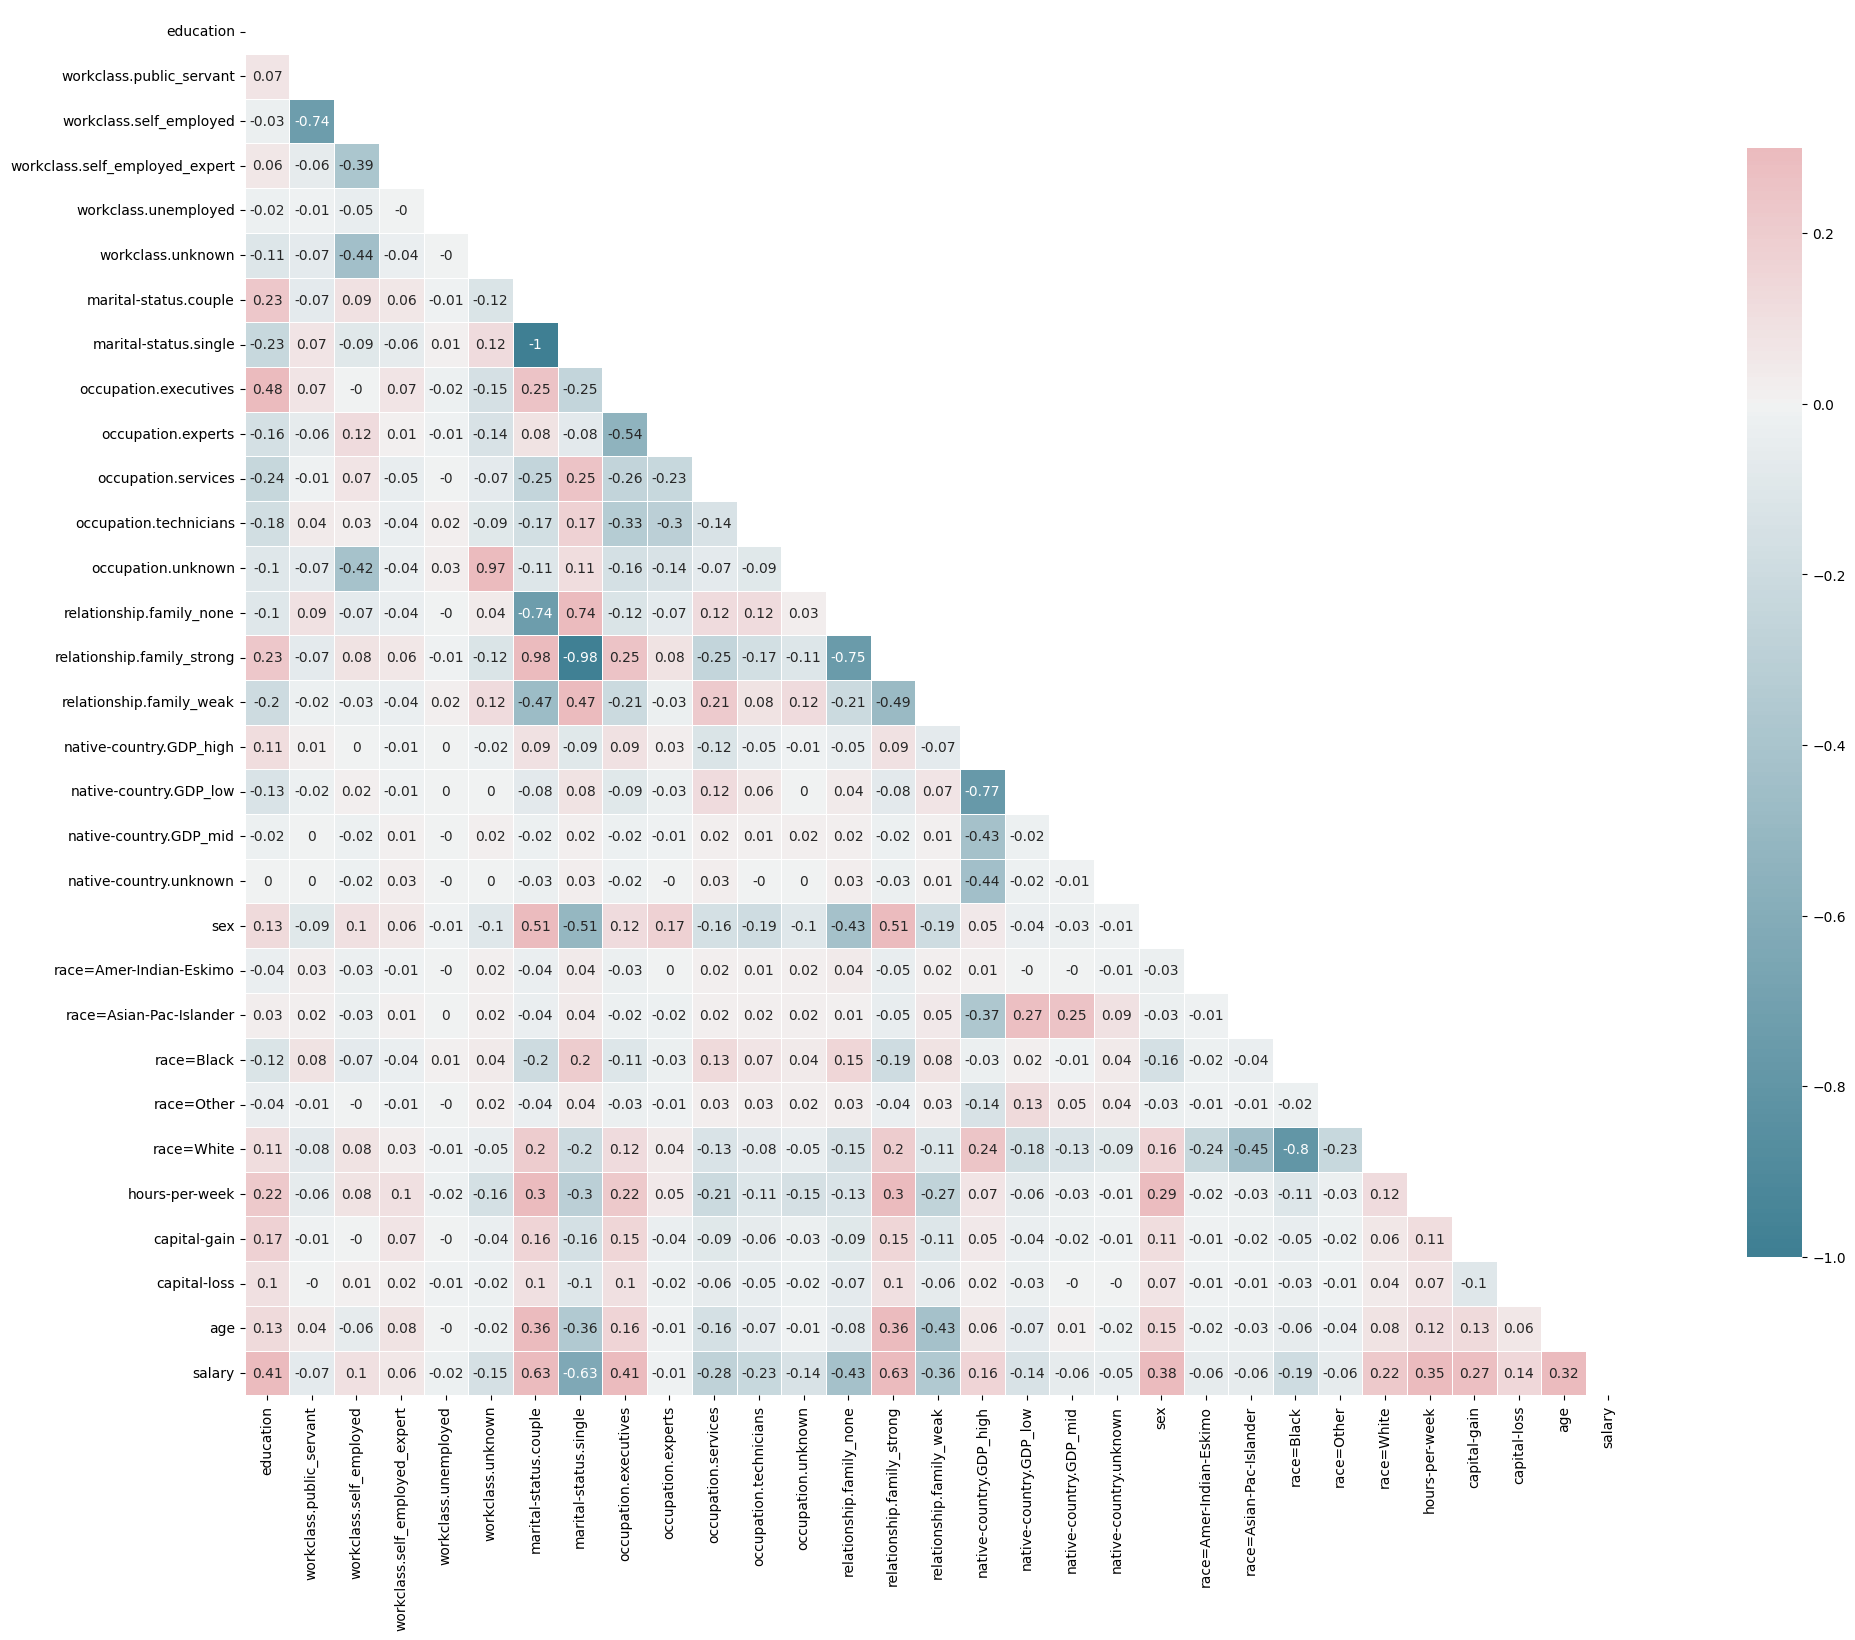

In [43]:
# Re-ordering columns
cols = training_dataset.columns.tolist()
cols.sort(key = 'salary'.__eq__)
training_dataset = training_dataset.reindex(columns=cols)

# Evaluation correlations
corr_matrix = evaluate_correlation(training_dataset)

# Generate a correlation matrix heat map
plot_correlation(corr_matrix, width=30)

Having irrelevant features in the data can decrease the accuracy of the models and force the model to learn irrelevant features.

We can now see a break-down of the feature importance with regard to the "salary" variable and remove all features that have a very low correlation.

In [47]:
# Filter features above a certain correlation threshold 
threshold = 0.08
feature_list_clean = corr_matrix["salary"].loc[abs(corr_matrix["salary"]) > threshold].index.tolist()

# Filter training and test datasets
training_dataset_clean = training_dataset[feature_list_clean]
test_dataset_clean = test_dataset[feature_list_clean]

# Printing remaining features
print( "Remaining features:")
training_dataset_clean.columns.tolist()

Remaining features:


['education',
 'workclass.self_employed',
 'workclass.unknown',
 'marital-status.couple',
 'marital-status.single',
 'occupation.executives',
 'occupation.services',
 'occupation.technicians',
 'occupation.unknown',
 'relationship.family_none',
 'relationship.family_strong',
 'relationship.family_weak',
 'native-country.GDP_high',
 'native-country.GDP_low',
 'sex',
 'race=Black',
 'race=White',
 'hours-per-week',
 'capital-gain',
 'capital-loss',
 'age',
 'salary']

## 5.6 Model Training and Test dataset creation
We can now finally separate the datasets into features & labels vectors to be called by classification models. 

In [48]:
y_train = training_dataset_clean["salary"]
X_train = training_dataset_clean.drop("salary", axis=1)

y_test = test_dataset_clean["salary"]
X_test = test_dataset_clean.drop("salary", axis=1)

# optional (validation set done later during cross-validation)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# 6. Classification models definition and training

## 6.1 Define models and hyperparameters

In [64]:

stacking_models_list = [
                        ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200)), 
                        ('RandForest', RandomForestClassifier(n_estimators=200)), 
                        ('AdaLogit', AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200)),
                        ('AdaTree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=200)), 
                        ('Tree', DecisionTreeClassifier()), 
                        ('Lbgm', LGBMClassifier()),
                        ('LogisticReg', LogisticRegression(max_iter=500))
                        ]

models_dict_list = [
            {"name": "SGDC", "model": SGDClassifier(loss='log', n_jobs=-1), "grid": {} },
            {"name": "LogisticReg", "model": LogisticRegression(max_iter=500), "grid": {'C' : np.logspace(-4, 4, 50), 'penalty' : ['l1', 'l2']} },
            {"name": "NaiveBayes", "model": GaussianNB(), "grid": {} },
            {"name": "LinSuppVectClass", "model": LinearSVC(max_iter=2000), "grid": {} },
            {"name": "SuppVectClass", "model": SVC(max_iter=-1), "grid": {} },
            {"name": "kNN", "model": KNeighborsClassifier(n_neighbors=5), "grid": {} },
            {"name": "RandForest", "model": RandomForestClassifier(n_estimators =500), "grid": {} },
            {"name": "XtraTree", "model": ExtraTreesClassifier(), "grid": {} },
            {"name": "GradBoost", "model": GradientBoostingClassifier(), "grid": {} },
            {"name": "CatBoost", "model": CatBoostClassifier(verbose=False), "grid": {} },
            {"name": "XGBoost", "model": XGBClassifier(objective = 'binary:logistic'), "grid": {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6), 'subsample': stats.uniform(0.3, 0.9), 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'colsample_bytree': stats.uniform(0.5, 0.9), 'min_child_weight': [1, 2, 3, 4]} },  
                       
            {"name": "Lbgm", "model": LGBMClassifier(), "grid": {} },
            {"name": "DecisionTree", "model": DecisionTreeClassifier(), "grid": {} },
            {"name": "Ada_Logit", "model": AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=500)), "grid": {} },
            {"name": "Ada_xgbc", "model": AdaBoostClassifier(base_estimator=XGBClassifier()), "grid": {} },
            {"name": "Bagging_Logit", "model": BaggingClassifier(base_estimator=LogisticRegression(max_iter=500)), "grid": {} },
            {"name": "Bagging_tree", "model": BaggingClassifier(base_estimator=DecisionTreeClassifier()), "grid": {} },
            {"name": "Stacking", "model": StackingClassifier(stacking_models_list, final_estimator=GradientBoostingClassifier()), "grid": {} },
            ]
               

## 6.2 Standard model training (no CV, no hyper-parameters)

### Let's run each model with their default parameters and evaluate metrics

========== Running model: SGDC (duration: 0:00:00)
==> Classification report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85     12435
           1       0.54      0.83      0.66      3846

    accuracy                           0.79     16281
   macro avg       0.74      0.81      0.75     16281
weighted avg       0.84      0.79      0.81     16281

==> Confusion_matrix:
 [[9708 2727]
 [ 641 3205]]
No feature importance method.
========== Running model: LogisticReg (duration: 0:00:03)
==> Classification report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86     12435
           1       0.55      0.81      0.66      3846

    accuracy                           0.80     16281
   macro avg       0.74      0.80      0.76     16281
weighted avg       0.84      0.80      0.81     16281

==> Confusion_matrix:
 [[9922 2513]
 [ 724 3122]]
No feature importance method.
========== Running mo

/home/albator/.cache/pypoetry/virtualenvs/adv-ml-techniques-for-imbalanced-dataset-6BVEZe3K-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/albator/.cache/pypoetry/virtualenvs/adv-ml-techniques-for-imbalanced-dataset-6BVEZe3K-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/albator/.cache/pypoetry/virtualenvs/adv-ml-techniques-for-imbalanced-dataset-6BVEZe3K-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and


========== Running model: Bagging_Logit (duration: 0:00:08)
==> Classification report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86     12435
           1       0.55      0.81      0.66      3846

    accuracy                           0.80     16281
   macro avg       0.74      0.81      0.76     16281
weighted avg       0.84      0.80      0.81     16281

==> Confusion_matrix:
 [[9921 2514]
 [ 720 3126]]
No feature importance method.
========== Running model: Bagging_tree (duration: 0:00:00)
==> Classification report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.85     12435
           1       0.53      0.82      0.64      3846

    accuracy                           0.78     16281
   macro avg       0.73      0.80      0.74     16281
weighted avg       0.84      0.78      0.80     16281

==> Confusion_matrix:
 [[9625 2810]
 [ 699 3147]]
No feature importance method.
==========

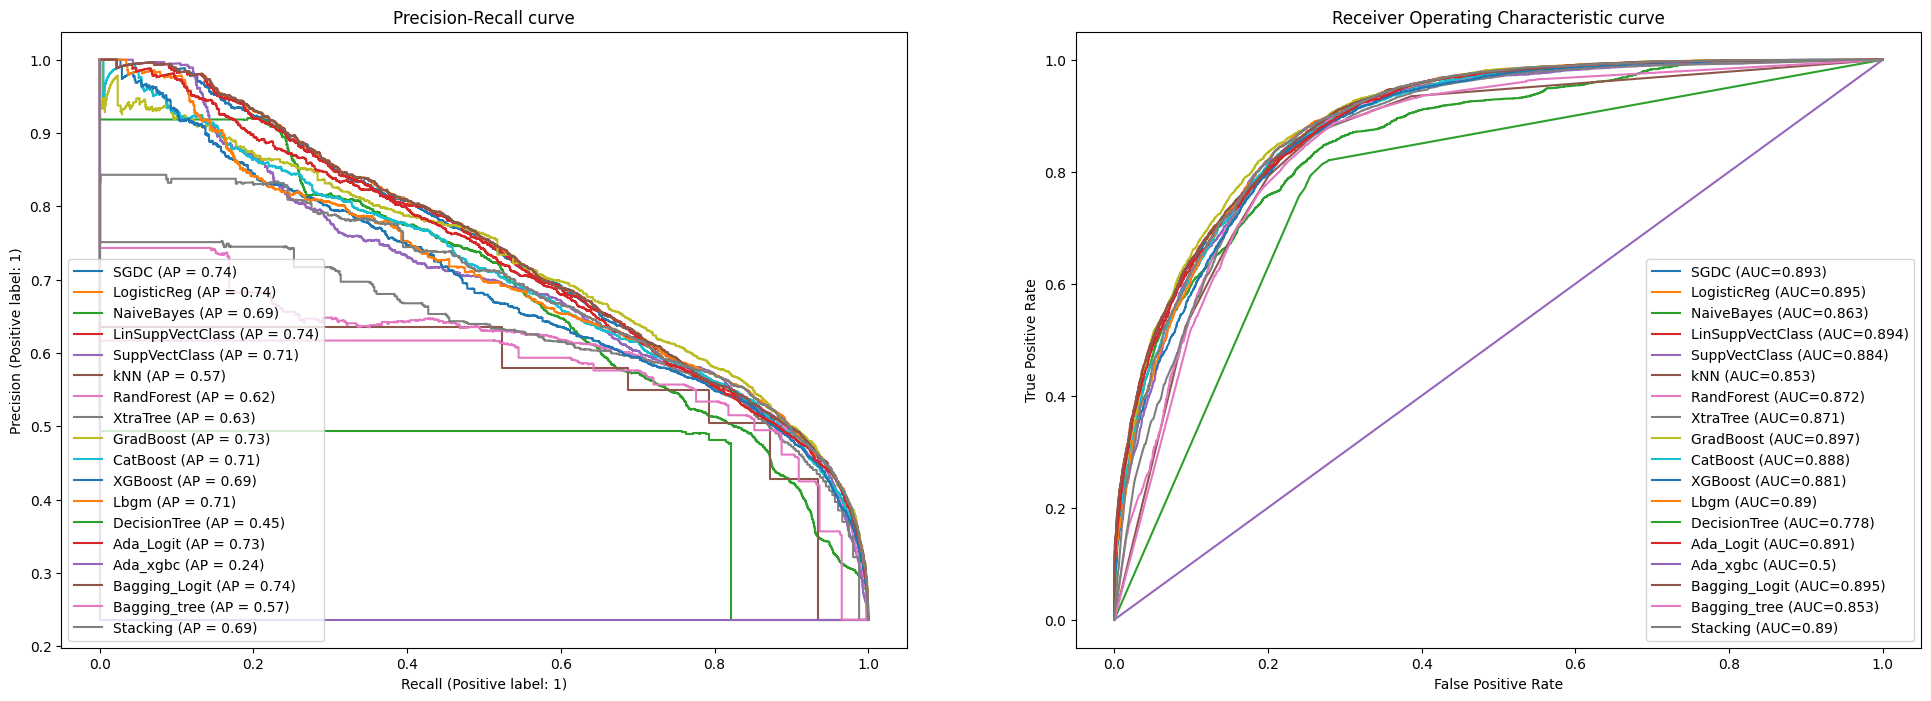

=== RESULTS SUMMARY ===


,precision,recall,f1-score,accuracy,AUC score
Model,,,,,
LogisticReg,0.843,0.801,0.812,0.801,0.895
Bagging_Logit,0.843,0.801,0.812,0.801,0.895
XtraTree,0.840,0.799,0.810,0.799,0.871
Ada_Logit,0.841,0.797,0.809,0.797,0.891
kNN,0.837,0.798,0.809,0.798,0.853
RandForest,0.845,0.797,0.809,0.797,0.872
GradBoost,0.851,0.796,0.809,0.796,0.897
LinSuppVectClass,0.843,0.796,0.808,0.796,0.894
SuppVectClass,0.844,0.796,0.808,0.796,0.884


In [65]:
fig, axes = plt.subplots(1,2, figsize=(24,8))
 
results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])
feature_importance_df = pd.DataFrame(index=X_train.columns.tolist())

for model_dict in models_dict_list:
    
    # Extract model
    model_name = model_dict["name"]
    model = model_dict["model"]
    
    # Training model
    print("========== Running model: "+model_name, end='')
    start_time = datetime.now()
    
    model.fit(X_train, y_train)
    y_true = y_test.to_numpy()
    y_pred = model.predict(X_test) 
    
    print(' (duration: {})'.format(str(datetime.now() - start_time).split('.')[0]))
    
    # Evaluate probabilities
    try:
        y_predict_proba = model.predict_proba(X_test)[:,1]
    except AttributeError:
        y_predict_proba = model.decision_function(X_test)  

    # Print metrics reports
    class_report = classification_report(y_true, y_pred)
    print("==> Classification report:\n",class_report)
    confus_matrix = confusion_matrix(y_true, y_pred)
    print("==> Confusion_matrix:\n",confus_matrix)
    
    # Evauate metrics for weighted support
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division = 0)

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)    
    auc_score = auc(fpr, tpr)
    
    # Evaluate Features importance (if method exists)
    try:
        feature_importance_df[model_name] = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist())
        print()
    except:
        print("No feature importance method.")
        
    # Store parameters
    results_df.loc[len(results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
    
    # Plot PR curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax = axes[0], name=model_name)
    axes[0].set_title('Precision-Recall curve',fontsize = 12)
    axes[0].grid()
    
    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax = axes[1], name=model_name+" (AUC="+str(round(auc_score,3))+")")
    axes[1].set_title('Receiver Operating Characteristic curve',fontsize = 12)
    axes[1].legend(loc="lower right")
    axes[1].grid()

plt.show()
print("=== RESULTS SUMMARY ===")
results_df = results_df.set_index('Model')
results_df.sort_values("f1-score", inplace = True, ascending=False)
results_df
    

F1-score is usually a better metric for imbalance dataset.   
However since we balanced the datatset using SMOTE, looking at the ROC-AUC curve should also be viable and provide a more subttle idea how the model segregates True Positive Rate vs False Positive Rate.   

The P-R curve is also a very good visual measure to compare precision vs recall.   
A good classifier should have both high precision and high recall.   
In other words a good classifier should be good at whatever it predicted (high precision) but also good at picking the correct items (high recall).

### Features importance (if method exists )

In [66]:
feature_importance_df

,RandForest,XtraTree,GradBoost,CatBoost,XGBoost,Lbgm,DecisionTree,Ada_xgbc
education,0.071091,0.060378,0.085736,6.086450,0.042854,192,0.064142,0.0
workclass.self_employed,0.010273,0.008097,0.005029,1.961555,0.007680,90,0.014671,0.0
workclass.unknown,0.003225,0.005284,0.000937,0.583103,0.008598,19,0.001455,0.0
marital-status.couple,0.124693,0.123293,0.164510,9.548004,0.589008,104,0.000000,0.0
marital-status.single,0.131353,0.134071,0.345478,9.330001,0.000000,12,0.471482,0.0
occupation.executives,0.062919,0.073517,0.078710,3.605593,0.076351,71,0.076558,0.0
occupation.services,0.015200,0.024864,0.010728,1.661656,0.029928,45,0.008652,0.0
occupation.technicians,0.009967,0.013255,0.005137,1.269655,0.010623,63,0.007808,0.0
occupation.unknown,0.002211,0.003267,0.000177,0.431127,0.009296,22,0.001733,0.0
relationship.family_none,0.034424,0.040576,0.000016,1.031421,0.004287,37,0.001243,0.0


This table is somewhat a bit inconsistent.   
It is assumed that the different algorithms have a different implementation of the method leading to different perceptions of which features are important. 

## 6.3 Run each model again using StratifiedKFold Cross-Validation and evaluate metrics

In [344]:
CV_results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])

N_folds = 10

for model_dict in models_dict_list:

    # Prepare CV
    sKF = StratifiedKFold(n_splits=N_folds, shuffle=True)
    fold_results_df = pd.DataFrame(columns=['Fold', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])

    # Extract model
    model_name = model_dict["name"]
    fold_model_list = [model_dict["model"] for i in range(N_folds)]
    
    # Training model
    print("========== Running model: "+model_dict["name"])
    
   
    fold_no = 0
    print("==== Training fold: ", end='') 
    for train_index, val_index in sKF.split(X_train, y_train):
        
        # Training model on fold x
        print(str(fold_no)+" ", end='')        
        
        # Splitting datasets
        X_train_CV, y_train_CV = X_train.loc[train_index,:], y_train.loc[train_index]
        X_val_CV, y_val_CV = X_train.loc[val_index,:], y_train.loc[val_index]
        
        # Training model and predicting
        fold_model_list[fold_no].fit(X_train_CV, y_train_CV)
        y_true = y_val_CV.to_numpy()
        y_pred = fold_model_list[fold_no].predict(X_val_CV) 
     
        # Evauate metrics for weighted support
        accuracy = accuracy_score(y_true, y_pred)
        P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division = 0))
        
        # Store parameters for the BEST F1-score model (arbitrary selected)
        fold_results_df.loc[len(fold_results_df.index)] = [fold_no, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
        # print(fold_results_df)
        
        # next fold
        fold_no += 1

    # print results of the sKF validation
    print()
    fold_results_df.sort_values("f1-score", inplace = True, ascending=False)
    
    # select the BEST and WORST F1-score models and evaluate metrics on the TEST dataset
    best_fold_no = int(fold_results_df.iloc[0]["Fold"])    
    worst_fold_no = int(fold_results_df.iloc[N_folds-1]["Fold"])    
    
    # Display the fold model results
    tmp_df = fold_results_df.set_index('Fold')
    print(tmp_df)
    print("best fold No:", str(best_fold_no), "- worst fold No:", str(worst_fold_no))
    
    # Evaluate metrics for BEST F1-score model 
    y_pred = fold_model_list[best_fold_no].predict(X_val_CV) 
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
        
    # Store parameters for the BEST F1-score model
    CV_results_df.loc[len(CV_results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
    
    
# Display all BEST f1-score models 
print("========== BEST f1-score models:")
CV_results_df = CV_results_df.set_index('Model')
CV_results_df.sort_values("f1-score", inplace = True, ascending=False)
CV_results_df

========== Running model: SGDC
==== Training fold: 0 1 2 3 4 5 6 7 8 9 
      precision  recall  f1-score  accuracy  AUC score
Fold                                                  
0.0   0.867      0.865   0.865     0.865     0.892    
9.0   0.867      0.864   0.864     0.864     0.892    
5.0   0.866      0.863   0.863     0.863     0.892    
2.0   0.864      0.861   0.861     0.861     0.892    
6.0   0.861      0.861   0.861     0.861     0.892    
7.0   0.865      0.861   0.861     0.861     0.892    
3.0   0.857      0.857   0.857     0.857     0.892    
4.0   0.859      0.855   0.855     0.855     0.892    
8.0   0.855      0.855   0.855     0.855     0.892    
1.0   0.857      0.852   0.852     0.852     0.892    
best fold No: 0 - worst fold No: 1
========== Running model: LogisticReg
==== Training fold: 0 1 2 3 4 5 6 7 8 9 
      precision  recall  f1-score  accuracy  AUC score
Fold                                                  
1.0   0.874      0.872   0.871     0.872    

,precision,recall,f1-score,accuracy,AUC score
Model,,,,,
CatBoost,0.899,0.898,0.898,0.898,0.892
XGBoost,0.895,0.894,0.894,0.894,0.892
Stacking,0.888,0.888,0.888,0.888,0.892
GradBoost,0.886,0.885,0.885,0.885,0.892
Lbgm,0.884,0.884,0.884,0.884,0.892
RandForest,0.866,0.865,0.865,0.865,0.892
Bagging_Logit,0.867,0.864,0.864,0.864,0.892
SGDC,0.867,0.864,0.864,0.864,0.892
XtraTree,0.862,0.862,0.862,0.862,0.892


The choice to display the best fold model is arbitrary and highlighting the 

## 6.4 Search a grid of hpyer-parameters to find the best classifier 

In [ ]:

search = RandomizedSearchCV(regression, n_iter=10, cv=5, 
                            param_distributions={
                                    'max_depth': range(2, 10),
                                    'num_trees': range(10,2000),
                                    #'reg_lambda': range(1,10),
                                    #'min_data_in_leaf': range(1,5),
                                    #'model_size_reg': np.arange(0,2,0.1)
                                    #'num_leaves': range(2,5),
                        })

In [ ]:
for model_dict in models_dict_list:
    
search = GridSearchCV(estimator= LogisticRegression(solver='newton-cg'), 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)


search.fit(X,y)
search.best_params_

y_train_pred = search.predict(X_train)
mean_absolute_error(y_train, y_train_pred)

search.cv_results_

In [ ]:
# LGBM
parameters = {
    'out__min_treshold': np.arange(1000, 1901, 100),
    'reg__n_estimators': range(10,200),
    'reg__max_depth': range(2,10),
    'reg__num_leaves': range(10, 100)
}
random_search = RandomizedSearchCV(model, parameters, cv=3, n_jobs=-1, n_iter=10, scoring='neg_mean_absolute_percentage_error')

In [ ]:
skopt.BayesSearchCV


In [ ]:
ada_search = {
    'model': [AdaBoostRegressor()],
    'model__learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'model__n_estimators': Integer(1, 1000),
    'model__loss': Categorical(['linear', 'square', 'exponential'])
    
}gb_search = {
    'model': [GradientBoostingRegressor()],
    'model__learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'model__n_estimators': Integer(1, 1000),
    'model__loss': Categorical(['ls', 'lad', 'quantile'])
}

In [ ]:
image.png